In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pprint import pprint
from scipy.cluster.hierarchy import dendrogram
import pandas as pd
import pickle

In [4]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="/home/consulting/Jupyter/smnoh/font/NanumGothic.ttf").get_name()
rc('font', family=font_name)

### 그래프 생성

In [3]:
# connect PostgreSQL
def query_agens(query):
    import psycopg2 as pg2
    from psycopg2 import Error
    from datetime import datetime
    
    start_tm = datetime.now()
    conn = pg2.connect(database="kg_news",user="consulting", host="192.168.0.68", port="15432")
    cur = conn.cursor()

    path_query = "set graph_path = realestate_news_v3;"
    cur.execute(path_query)
    cur.execute(query)
    result = cur.fetchall()
    
    cur.close()
    conn.close()
    
    end_tm = datetime.now()
    print('START: ', str(start_tm))
    print('END: ', str(end_tm))
    print('ELAP: ', str(end_tm - start_tm))
    
    return result

In [4]:
query = """match (s:noun)-[p:predicate]->(o:noun) return s.word, p.verb, o.word"""
result = query_agens(query)
data = pd.DataFrame(result, columns=['subject', 'predicate', 'object'])
#data = data.loc[:50, :]
data

START:  2021-01-12 17:30:14.618107
END:  2021-01-12 17:30:14.637827
ELAP:  0:00:00.019720


,subject,predicate,object
0,정부,발표하다,임대주택 공급
1,정부,위하다,전세시장안정
2,정부,계획이다,전세 대책 발표
3,정부,진행하다,관계부처간 협의
4,정부,옳다,대응방안 마련
...,...,...,...
964,공공임대,필수적이다,지속성
965,공공임대,필수적이다,사업성
966,공공임대,줄여야한다,정부역할
967,공공임대,지적하다,공급대책


In [5]:
# 방향성 없는 graph 생성
G = nx.Graph()

# n1, n2 고유값 node 생성
node = list(data['subject'].append(data['object']))
node = list(set(node)) # 중복제거
G.add_nodes_from(node)

for i in data.index:
    G.add_edges_from([(data.subject[i], data.object[i], {'verb':data.predicate[i]})])

In [6]:
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 920\nNumber of edges: 886\nAverage degree:   1.9261'

### Hierarchical Graph Clustering using Node Pair Sampling
https://arxiv.org/pdf/1806.01664.pdf

In [5]:
def HC(G):
    n = G.number_of_nodes()
    g = G.copy()

    # 노드를 정수로 변환
    if set(g.nodes()) != set(range(n)):
        g = nx.convert_node_labels_to_integers(g, label_attribute='noun')
        f = g.copy()  # old label을 꺼내기 위해 저장
    
    # 노드의 weight 초기화 및 계산
    # 노드별 degree 할당 -> 노드 i의 degree = w[i], wtot=총연결수*2 ([u,v]/[(v,u)] 두 번씩 더해서)
    w = {u: 0 for u in range(n)}
    wtot = 0
    for (u,v) in g.edges():
        if 'weight' not in g[u][v]:
            g[u][v]['weight'] = 1
        weight = g[u][v]['weight']
        w[u] += weight
        w[v] += weight
        wtot += weight
        if u != v:
            wtot += weight

    # cluster 리스트 초기화
    s = {u: 1 for u in range(n)}
    
    cc = [] # connected components
    D = []  # dendrogram 리스트
    #print(g.nodes())

    # cluster 계산
    u = n
    while n > 0:
        # nearest-neighbor chain
        chain = [list(g.nodes())[0]]
        while chain != []:
            a = chain.pop()
            dmin = np.inf
            b = -1
            # nearest-neighbor를 찾는 부분
            for v in g.neighbors(a): 
                if v != a:
                    #논문에서의 distance (d(i,j))
                    d = w[v] * w[a] / float(g[a][v]['weight']) / float(wtot)
                    
                    if d < dmin:
                        b = v
                        dmin = d
                    elif d == dmin:
                        b = min(b,v) # a와 가장 가까운 b 탐색 
            d = dmin
            if chain != []:
                c = chain.pop()
                if b == c:
                    # dendrogram 리스트에 값 대임
                    D.append([a,b,d,s[a] + s[b]])
                    # 변경된 cluster 기준으로 네트워크 업데이트
                    g.add_node(u)
                    neighbors_a = list(g.neighbors(a))
                    neighbors_b = list(g.neighbors(b))
                    for v in neighbors_a:
                        g.add_edge(u,v,weight = g[a][v]['weight'])
                    for v in neighbors_b:
                        if g.has_edge(u,v):
                            g[u][v]['weight'] += g[b][v]['weight']
                        else:
                            g.add_edge(u,v,weight = g[b][v]['weight'])
                    g.remove_node(a)
                    g.remove_node(b)
                    n -= 1
                    # weight와 size 업데이트
                    w[u] = w.pop(a) + w.pop(b)
                    s[u] = s.pop(a) + s.pop(b)
                    # node index보다 높은 값으로 cluster index 지정
                    u += 1
                else:
                    chain.append(c)
                    chain.append(a)
                    chain.append(b)
            elif b >= 0:
                chain.append(a)
                chain.append(b)   
            else:
                # connected componet 제거
                cc.append((a,s[a]))
                g.remove_node(a)
                w.pop(a)
                s.pop(a)
                n -= 1
    # connected component를 덴드로그램에 저장
    
    a,s = cc.pop()
    
    for b,t in cc:
        s += t
        D.append([a,b,np.inf,s])
        a = u
        u += 1
        
    return reorder_dendrogram(np.array(D)),f

In [6]:
# dendrogram 입력 형태에 맞게 변환
def reorder_dendrogram(D):
    n = np.shape(D)[0] + 1
    order = np.zeros((2,n - 1),float)
    order[0] = range(n - 1)
    order[1] = np.array(D)[:,2]
    index = np.lexsort(order)
    nindex = {i:i for i in range(n)}
    nindex.update({n + index[t]:n + t for t in range(n - 1)})
    return np.array([[nindex[int(D[t][0])],nindex[int(D[t][1])],D[t][2],D[t][3]] for t in range(n - 1)])[index,:]

In [7]:
# dendrogram 형태의 결과값에서 원하는 클러스터 갯수만큼 클러스터 추출
def select_clustering(D, k):
    n = np.shape(D)[0] + 1
    k = min(k,n - 1)
    cluster = {i:[i] for i in range(n)}
    for t in range(n):
        if len(cluster.values())>k:
            cluster[n + t] = cluster.pop(int(D[t][0])) + cluster.pop(int(D[t][1]))
            
    cluster_array=sorted(cluster.values(), key = len, reverse = True)
    
    return cluster_array

#### 뉴스SPO데이터 적용

##### 클러스터링 수행
- 1.1에서 생성한 G 사용

In [8]:
z,g = HC(G) #노드명이 프린트됨

n = 5
c = select_clustering(z,n) #max 군집 개수: np.shape(z)[0] -> 이건 항상 노드개수-1 ??? 
size = [len(i) for i in c]

# 첫번째 군집의 사이즈만 너무 큼 => Giant Component 대상으로 클러스터링 재수행
print('#of clusers / size of each cluster')
for k in range(1,10):
    c = select_clustering(z,k)
    print(k, ' / ', [len(i) for i in c])

NameError: name 'G' is not defined

거리가 infinite인 노드들로 인해 덴드로그램 그리기 불가능

ValueError: Axis limits cannot be NaN or Inf

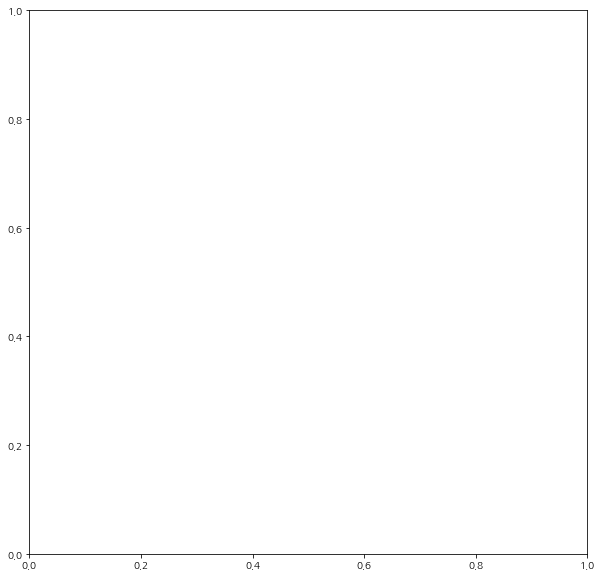

In [11]:
plt.figure(figsize=(10, 10))
dendrogram(z)
plt.show()

#### Giant Component 

##### Giant cluster에 속한 SPO 추출(최초수행시)

In [12]:
gc_nodes = list(sorted(nx.connected_components(G), key=len, reverse=True)[0])

#주어
query1 = "match (s:noun)-[r:predicate]->(o:noun) where s.word in " + str(gc_nodes) + "return s.word, r.verb, o.word"
result1 = query_agens(query1)
data1 = pd.DataFrame(result1, columns=['subject', 'predicate', 'object'])

#목적어
query2 = "match (s:noun)-[r:predicate]->(o:noun) where o.word in " + str(gc_nodes) + "return s.word, r.verb, o.word"
result2 = query_agens(query2)
data2 = pd.DataFrame(result2, columns=['subject', 'predicate', 'object'])

gc_df = pd.concat([data1, data2], ignore_index=True)
gc_df = gc_df.drop_duplicates()

START:  2021-01-08 17:09:53.069823
END:  2021-01-08 17:09:53.093946
ELAP:  0:00:00.024123
START:  2021-01-08 17:09:53.096453
END:  2021-01-08 17:09:53.118919
ELAP:  0:00:00.022466


그래프 생성

In [13]:
GC = nx.Graph()

#노드추가
nouns = list(gc_df.subject) + list(gc_df.object)
node = set(nouns)
GC.add_nodes_from(node)

#엣지추가
for i in gc_df.index:
    GC.add_edges_from([(gc_df.subject[i], gc_df.object[i], {'verb':gc_df.predicate[i]})])

In [14]:
print(nx.info(GC))
print(len(sorted(nx.connected_components(GC), key=len, reverse=True)))

Name: 
Type: Graph
Number of nodes: 569
Number of edges: 662
Average degree:   2.3269
1


##### 피클로 저장한 GC 호출

In [9]:
## Load pickle
with open("./NPS_clusters_images/GC_NPS","rb") as fr:
    GC = pickle.load(fr)


##### Giant Component  클러스터링 수행

In [10]:
z,g = HC(GC) 

# int로 변환된 라벨과 원래노드 매칭
# nx.convert_node_labels_to_integers의 label_attribute 옵션, nx.get_node_attributes 이용
old_nodes = nx.get_node_attributes(g,'noun')

modularity_list = []

# 최대 modularity를 찾기 위해 cluster 갯수 2~50개까지 계산
for cluster_num in range(1, 51):
    n=cluster_num
    tmp_cluster =select_clustering(z,n)
    #cluster별 keyword 치환
    for i in range(len(tmp_cluster)):
        for j in range(len(tmp_cluster[i])):
            tmp_cluster[i][j] = old_nodes[tmp_cluster[i][j]]
            
    
    modularity_list.append(nx.community.modularity(GC, tmp_cluster))
    
max_m = modularity_list.index(max(modularity_list))+1
print("modularity가 가장 높은 cluster 갯수:", max_m)

#n개의 군집으로 클러스터링
opt_clusters =select_clustering(z,max_m)
#각 군집별 사이즈
size = [len(i) for i in opt_clusters]
print("size of each cluster:",size)

modularity가 가장 높은 cluster 갯수: 20
size of each cluster: [64, 58, 52, 47, 35, 33, 30, 30, 29, 27, 27, 25, 20, 20, 18, 17, 15, 8, 8, 6]


- 군집 수 cutoff using Entropy?? (ranyi disparity)

In [11]:
import math

normal_size = []
total = sum(size)
for i in size:
    normal_size.append(i/total)

w=[]
for i in normal_size:
    w.append(i*math.log(i))

math.exp(-sum(w))  # 17개 이하인 군집은 버리기?? (정확한 해석법은 잘모름)

17.144568309134698

In [12]:
clusters = [] #원래의 명사로 변환하여 리스트에 담기
for i in range(len(opt_clusters)):  #opt_clusters : integer 노드로 구성된 클러스터들
    nouns = []
    for j in opt_clusters[i]:
        nouns.append(old_nodes[j])  #old_nodes: 원래노드명/정수변환 노드 매칭시킨 딕셔너리
    clusters.append(nouns)

opt_clusters와 개수 일치하는지 확인

In [13]:
size == [len(i) for i in clusters]

True

엣지리스트로부터 SPO 추출

In [14]:
#전체 그래프의 엣지리스트
edgelist = nx.get_edge_attributes(GC,'verb')

In [15]:
#클러스터별 SPO 추출
spolist = {}
for k in range(len(clusters)):
    nodepair = []
    for i in clusters[k]:
        for j in clusters[k]:
            a = (i,j)
            nodepair.append(a)
    spo = {}
    for i in nodepair:
        try:
            spo[i] = edgelist[i]           
        except KeyError:
            continue
    spolist[k] = spo

In [16]:
#추출된 SPO리스트에서 클러스터별 명사 개수 확인하여 대조
nounlist = []
for i in range(len(spolist)):
    keys = list(spolist[i].keys())
    nouns = []
    for i in keys:
        nouns.append(i[0])
        nouns.append(i[1])
    nouns = set(nouns)
    nounlist.append(nouns)

In [17]:
size1 = [len(nounlist[i]) for i in range(len(nounlist))]
size1 == size

True

##### 시각화

In [18]:
key_edges = {
    0:[('정부', '전세시장 안정'),('정부', '전세 대책 발표'),('정부', '전월세 대란 대책')],
    1:[('혼란', '임대차법'),('임대차법', '계약갱신청구권'),('전월세상한제', '임대차법'),('전세물량', '임대차법')],
    2:[('전세대출', '전세가격'),('전세대출', '전세보증금')],
    3:[('전셋값', '가격'),('전국', '전셋값')],
    4:[('집주인', '불만'),('청원글', '집주인')],
    5:[('대책', '공공임대'),],
    6:[('여러 요인', '전세난')],
    7:[('품귀현상', '전세'),('아파트매매', '전세수요')],
    8:[('저금리', '전세자금대출')],
    9:[('정책', '임차인'),('정책', '부동산시장')],
    10:[('내집마련', '세입자')],
    11:[('세입자 부담', '세액공제'),('세입자 부담', '임대차신고제'),('세액공제 확대', '세입자 부담')],
    12:[('국토교통부', '입장')],
    13:[('시장', '전세매물')],
    14:[('전세시장', '임대주택공급'),('안정화', '전세시장')],
    15:[('중저가 아파트', '상승세')],
    16:[('집값', '공시지가 상승'),('상승', '집값')],
    17:[('디딤돌대출', '금리')],
    18:[('전세대란', '2011년')],
    19:[('확대', '주택 공급')]
}

cluster 0


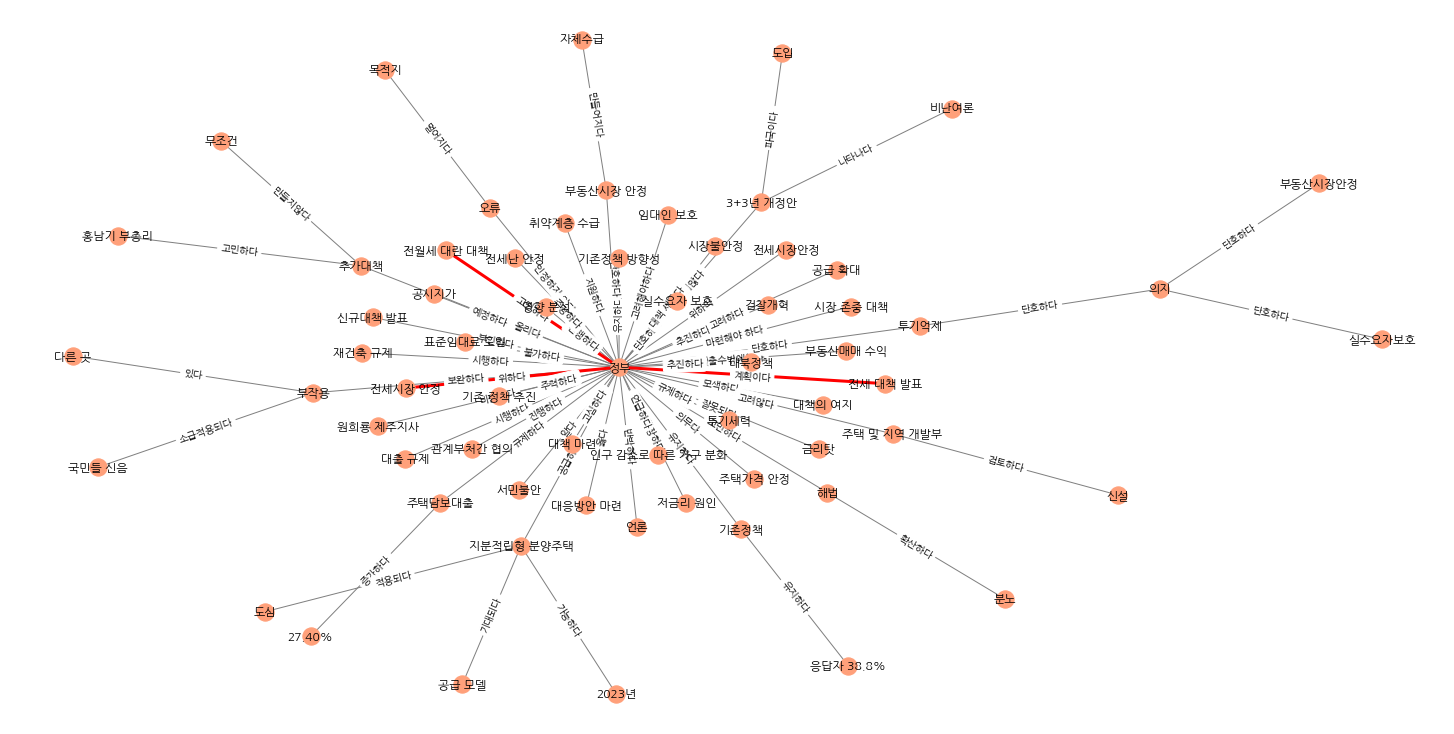

cluster 1


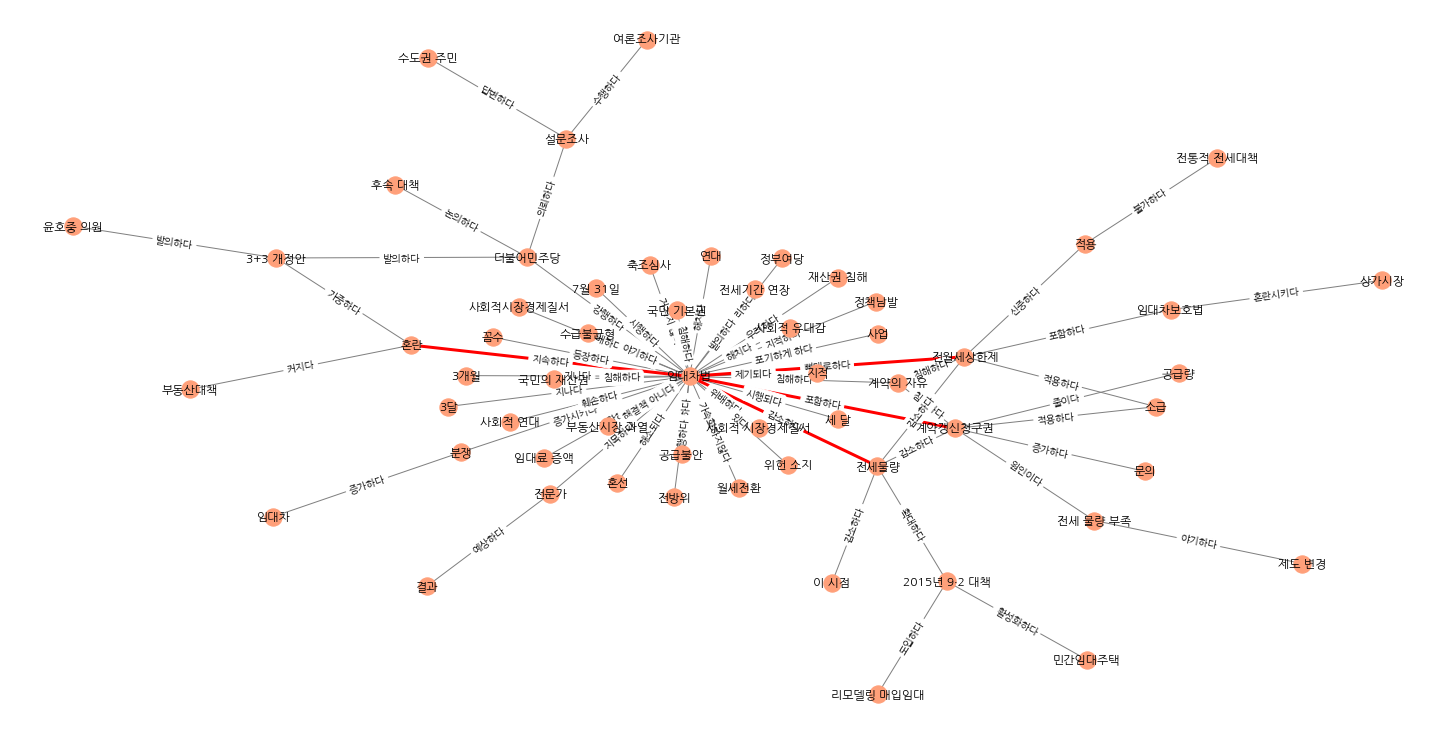

cluster 2


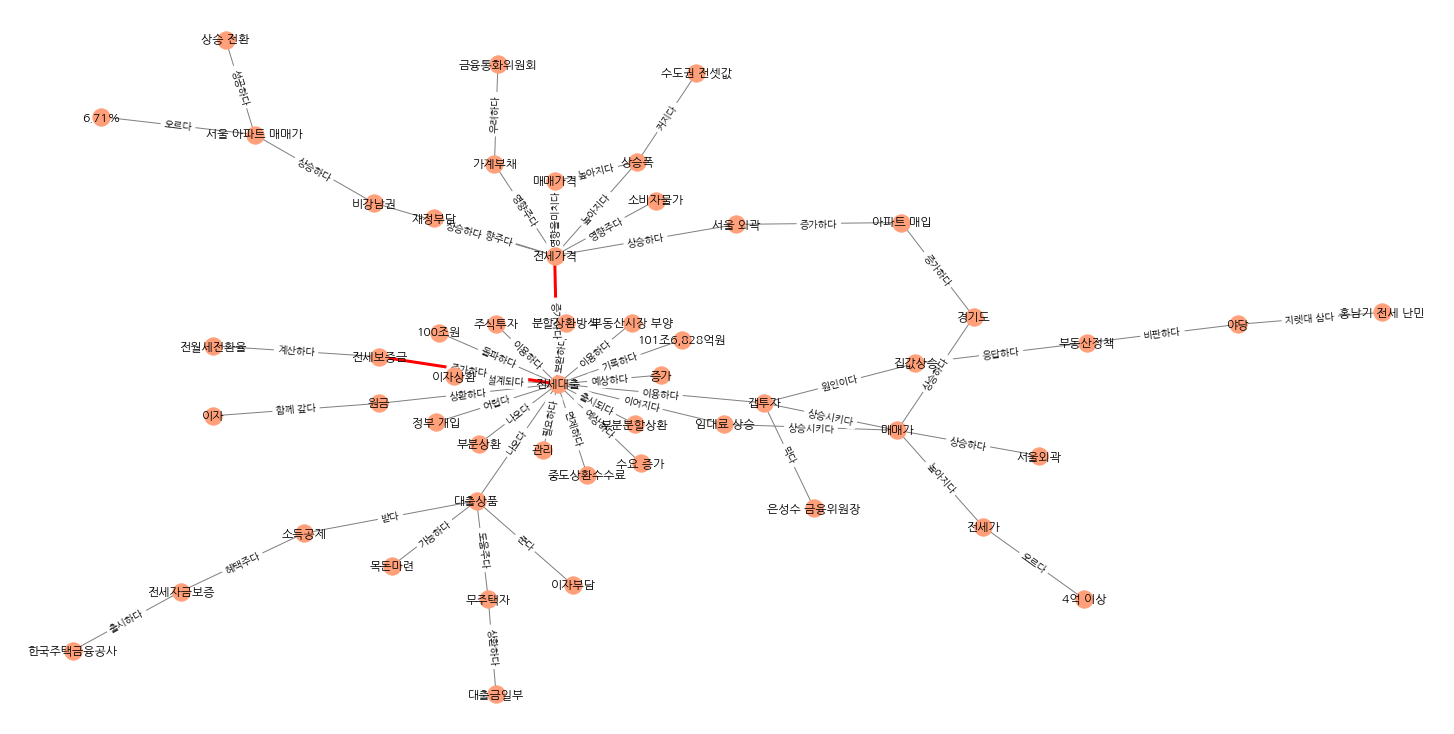

cluster 3


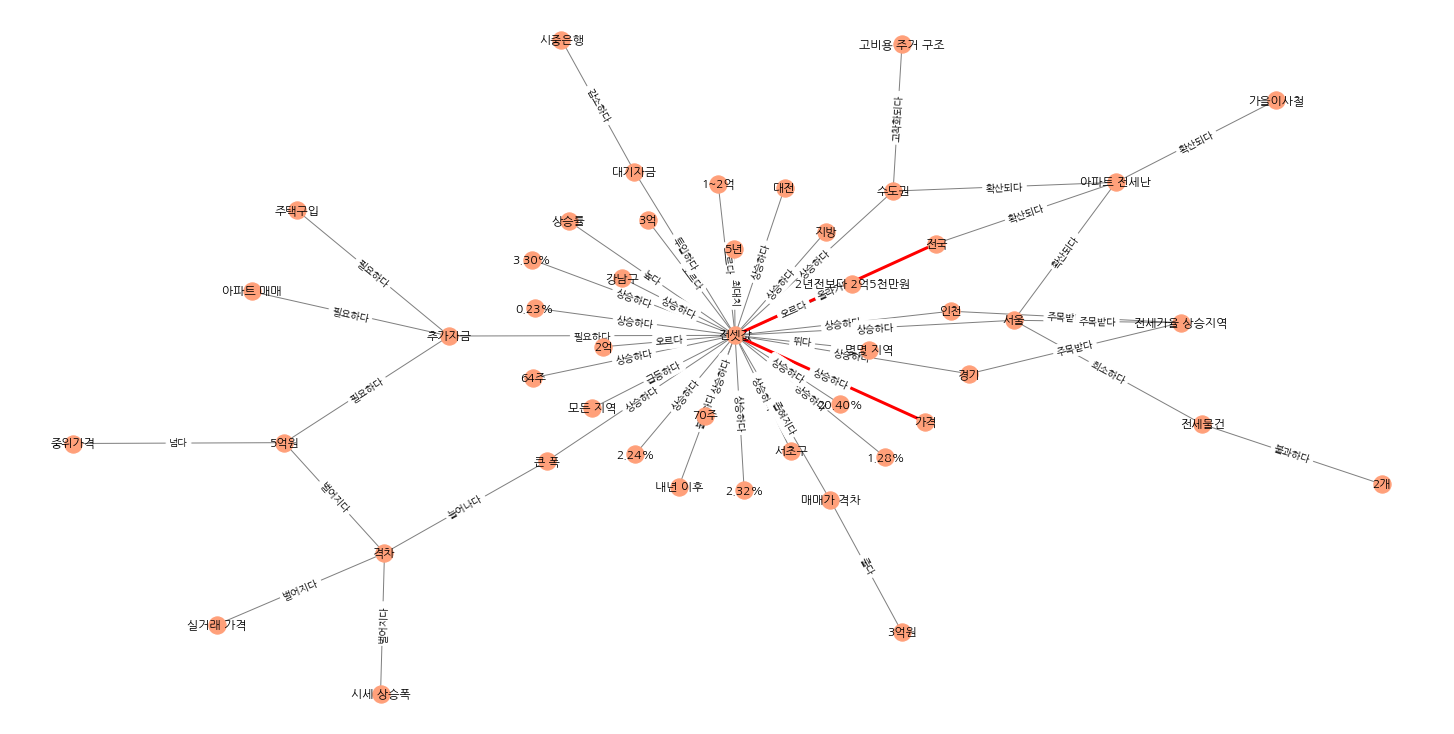

cluster 4


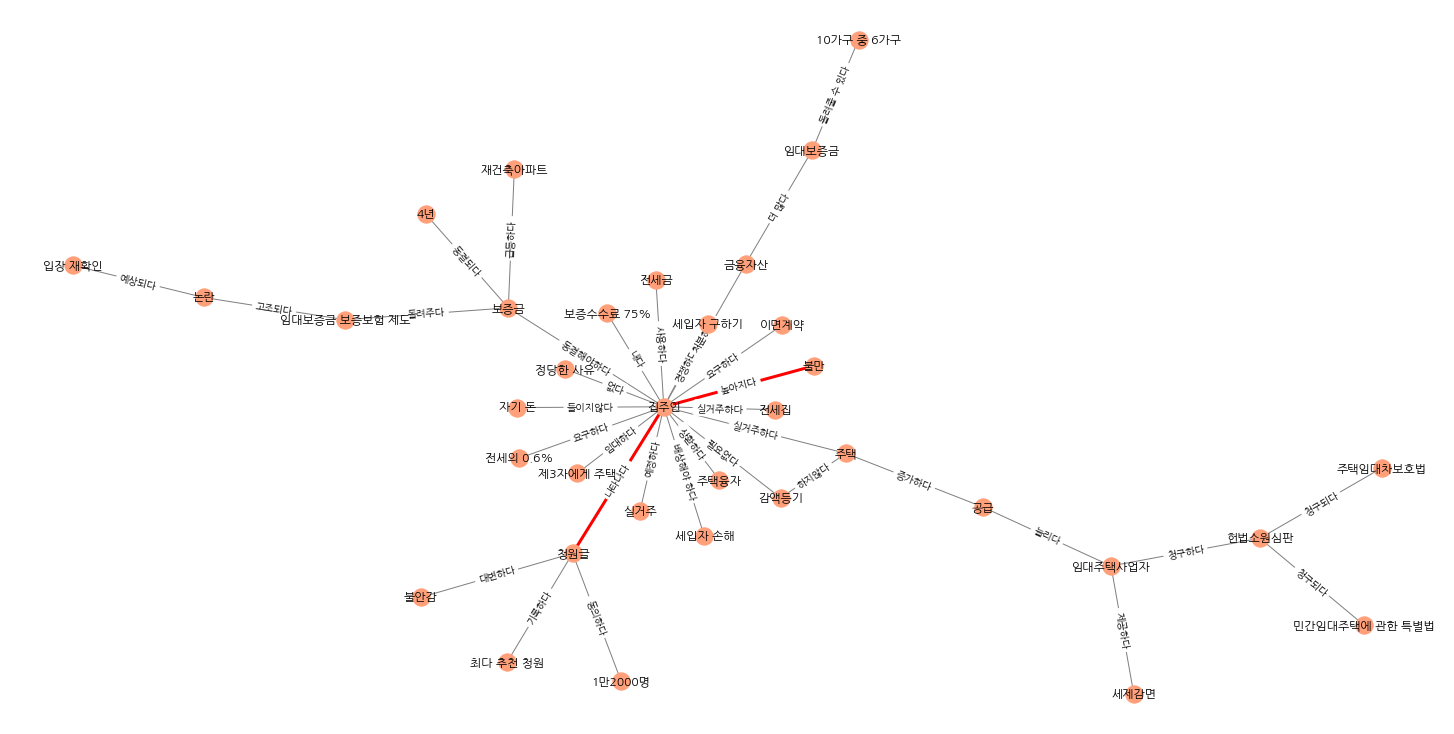

cluster 5


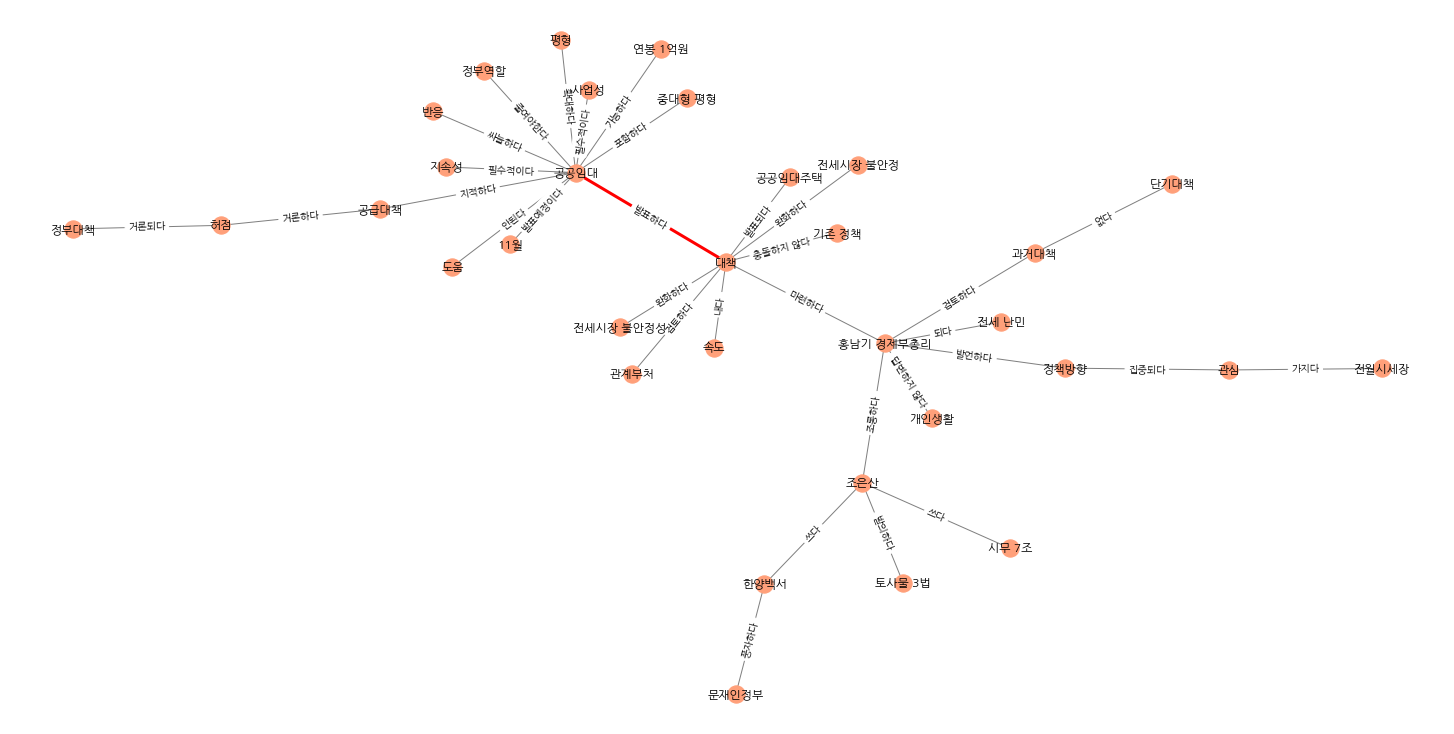

cluster 6


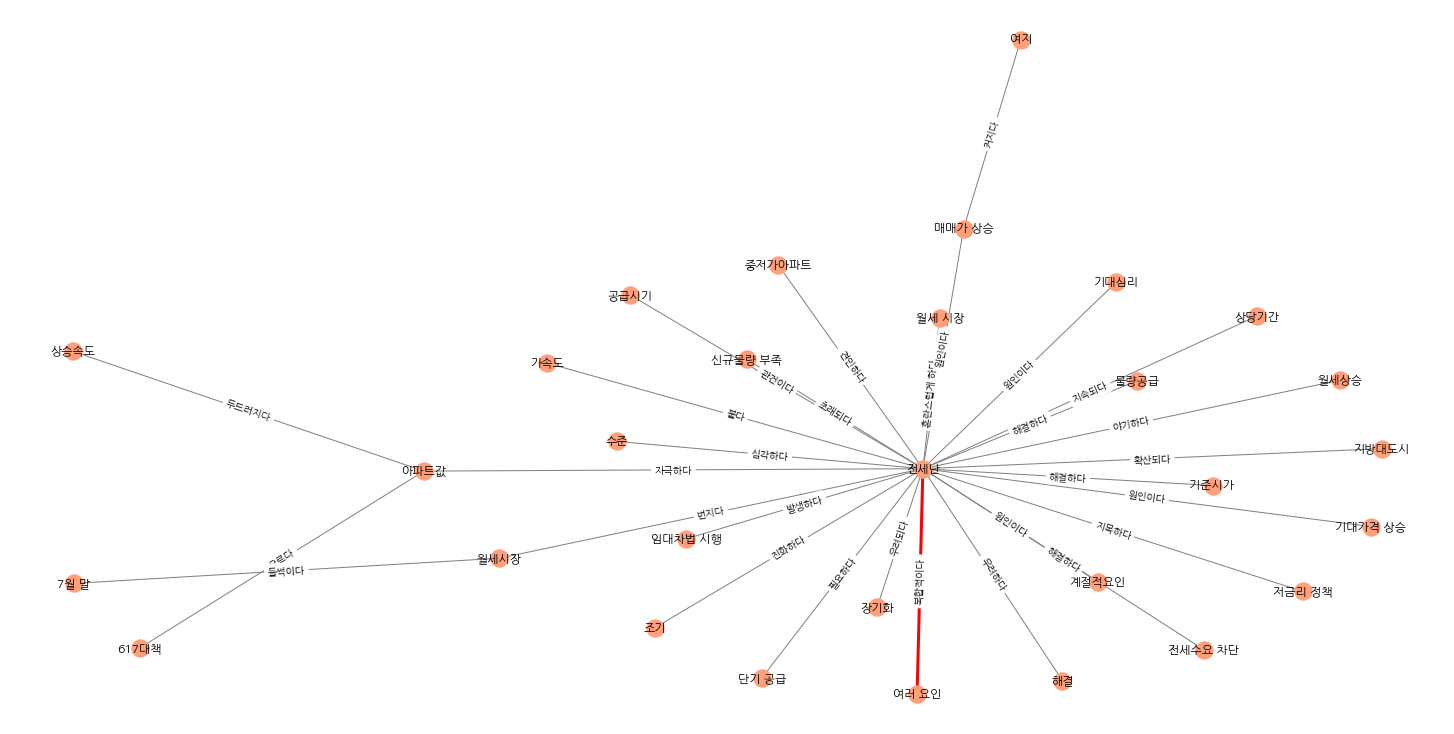

cluster 7


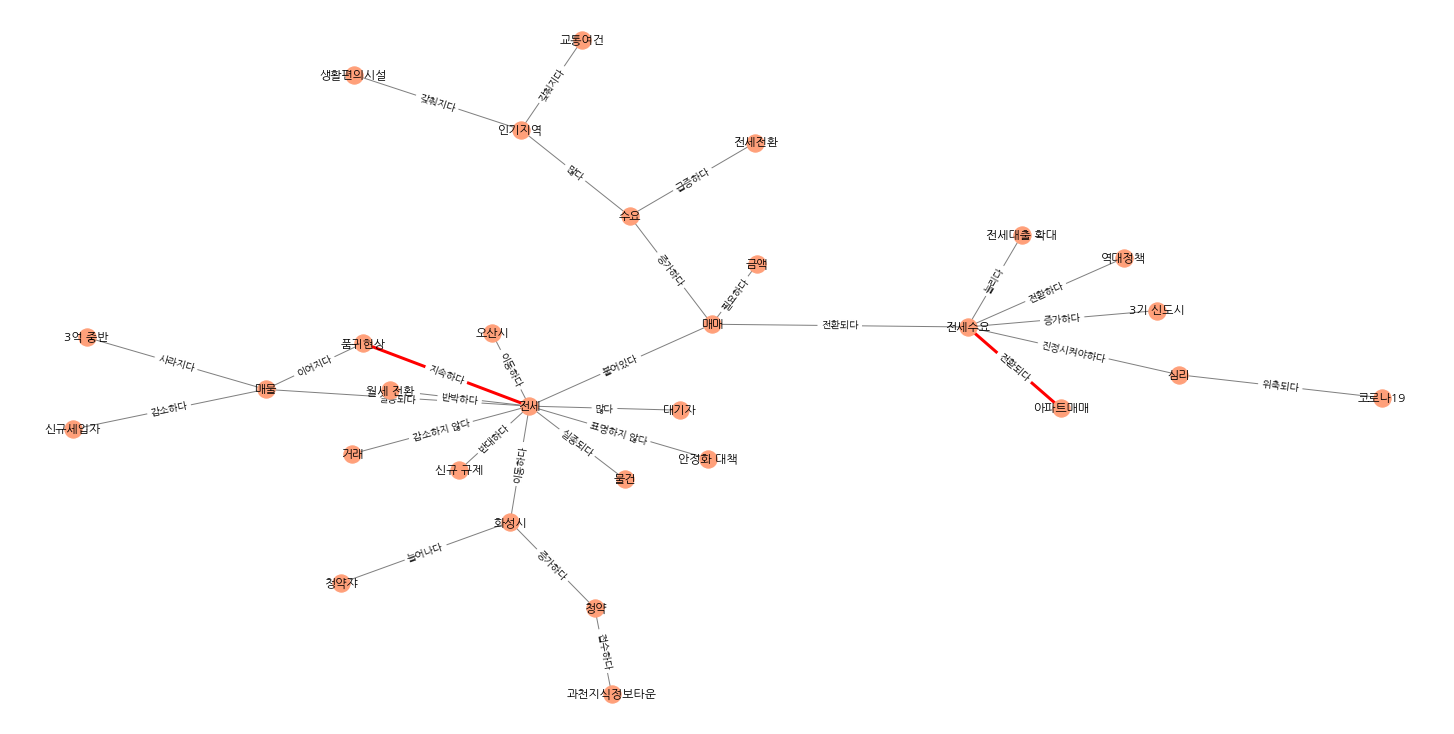

cluster 8


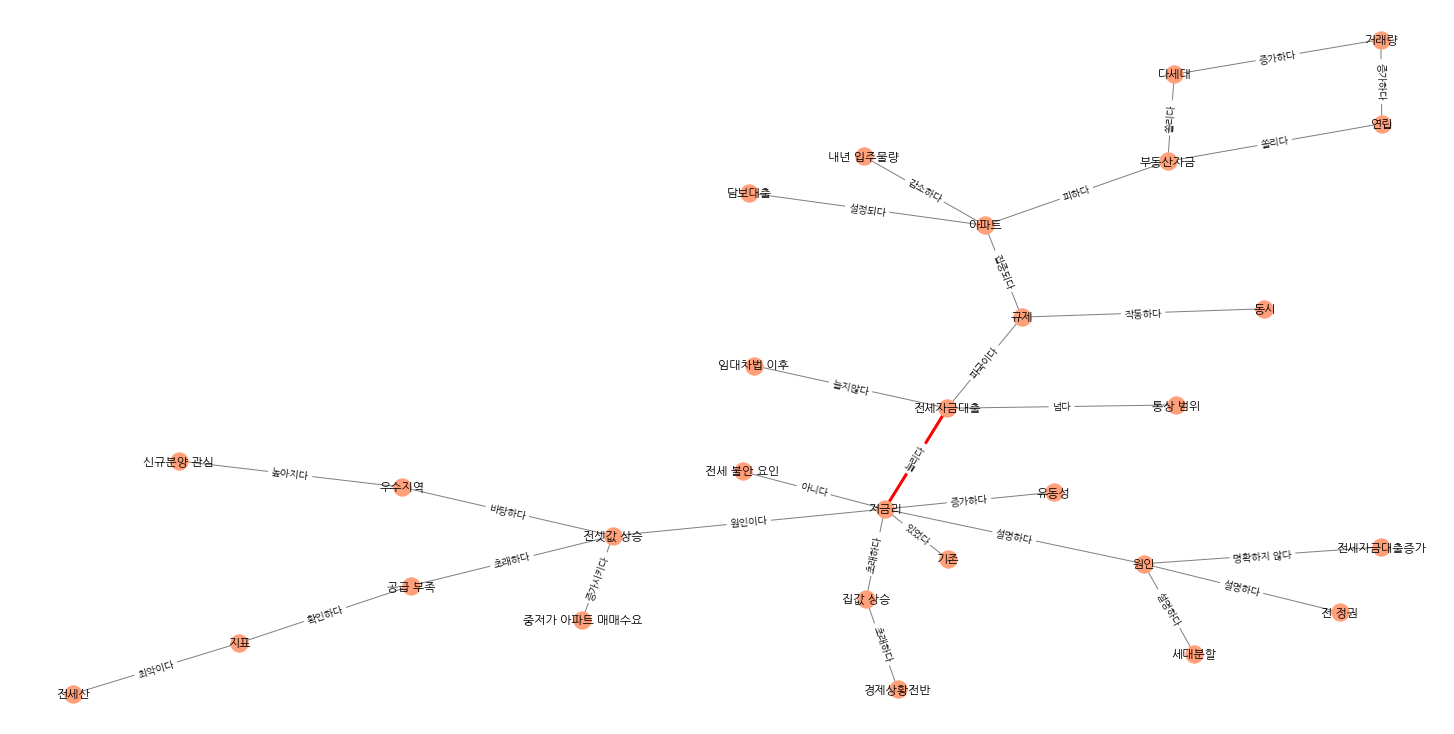

cluster 9


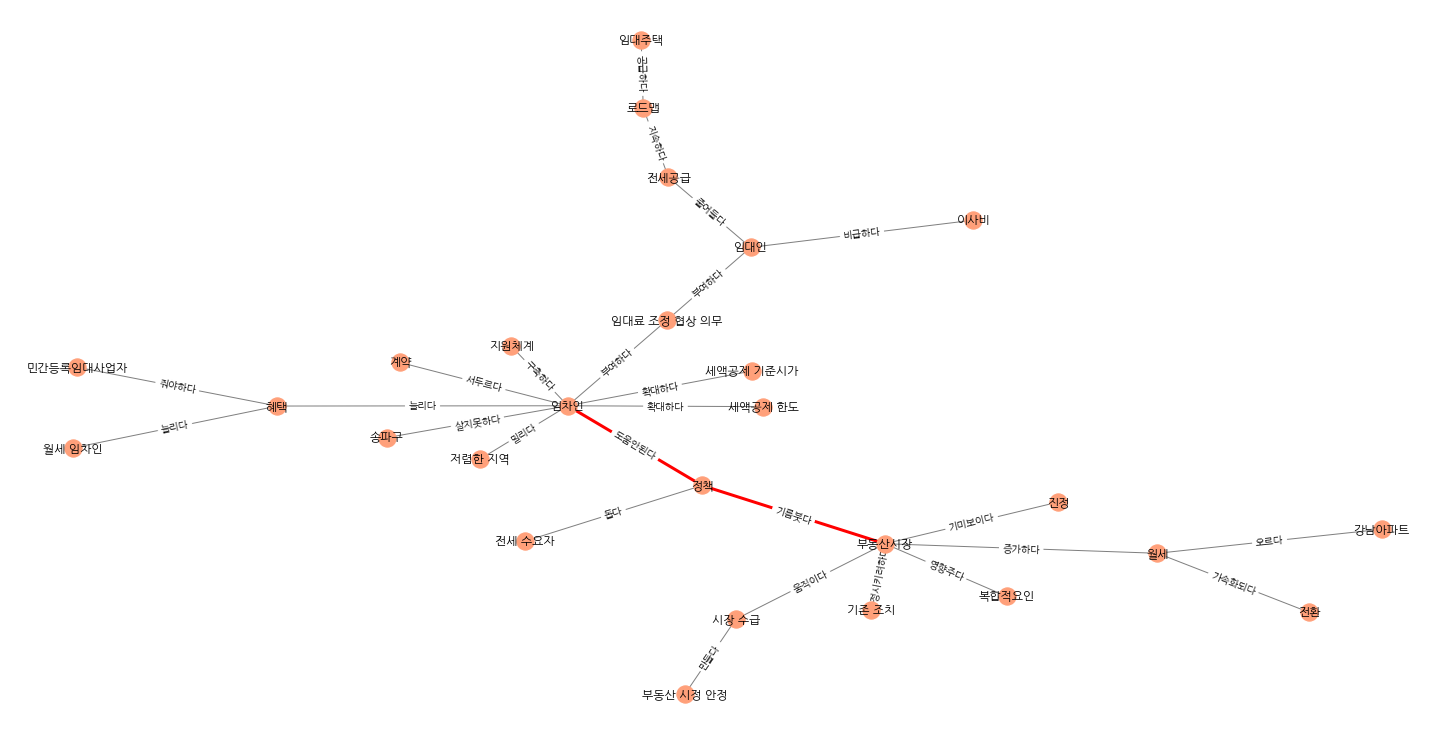

cluster 10


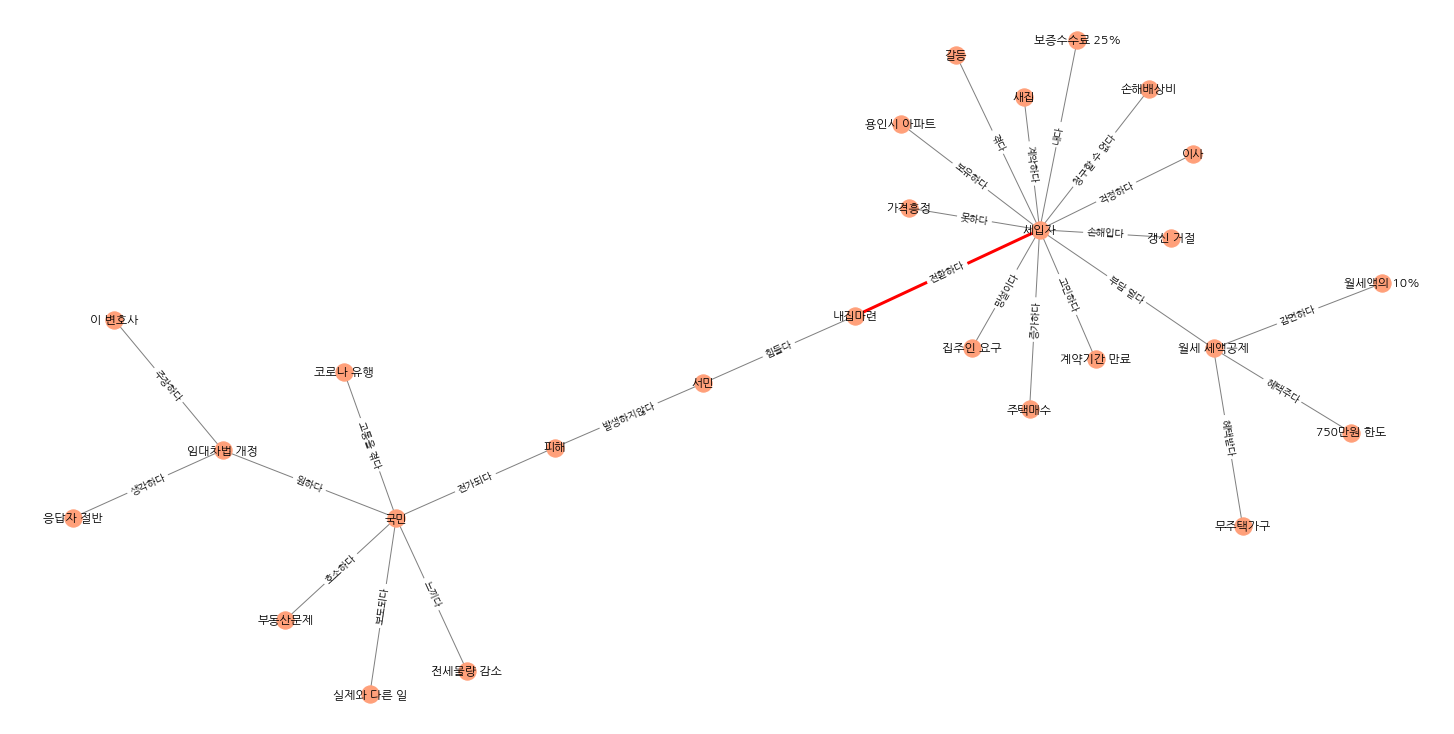

cluster 11


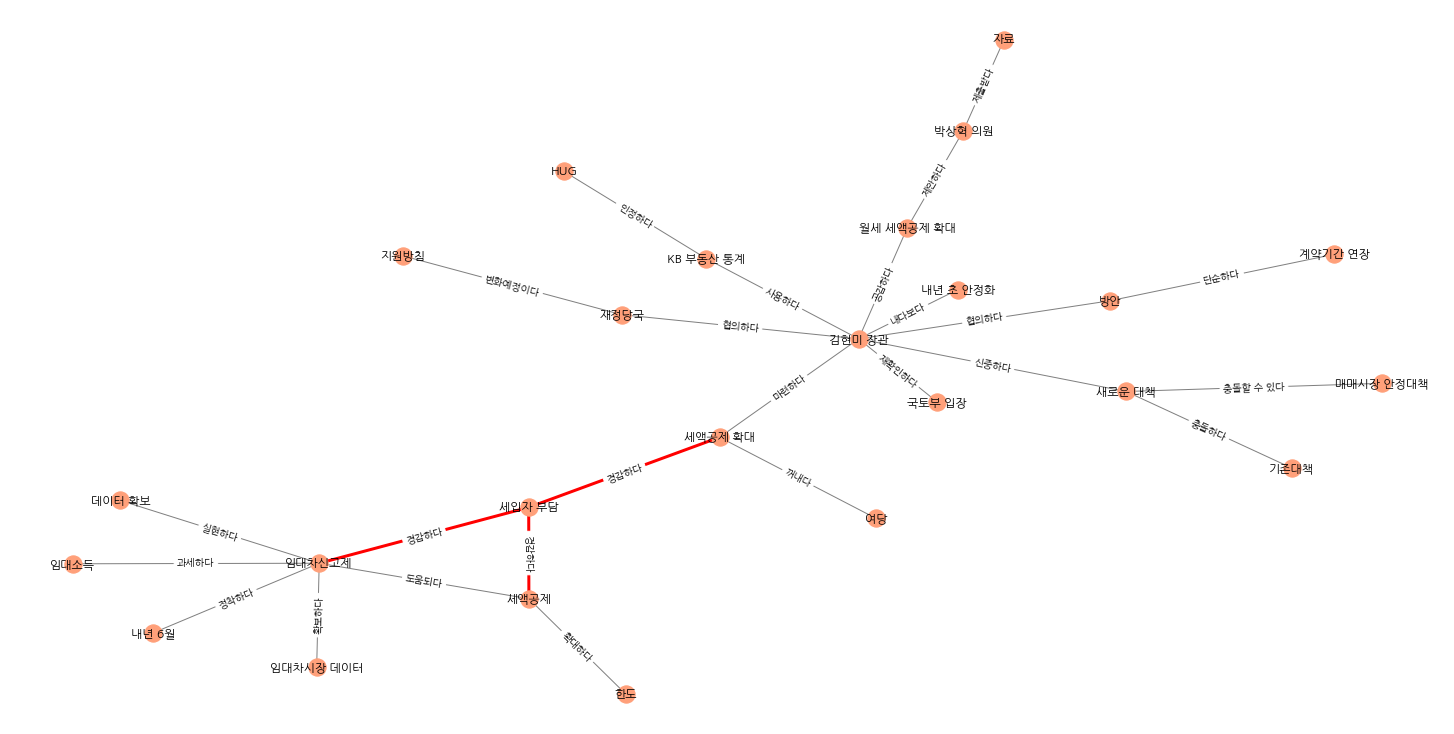

cluster 12


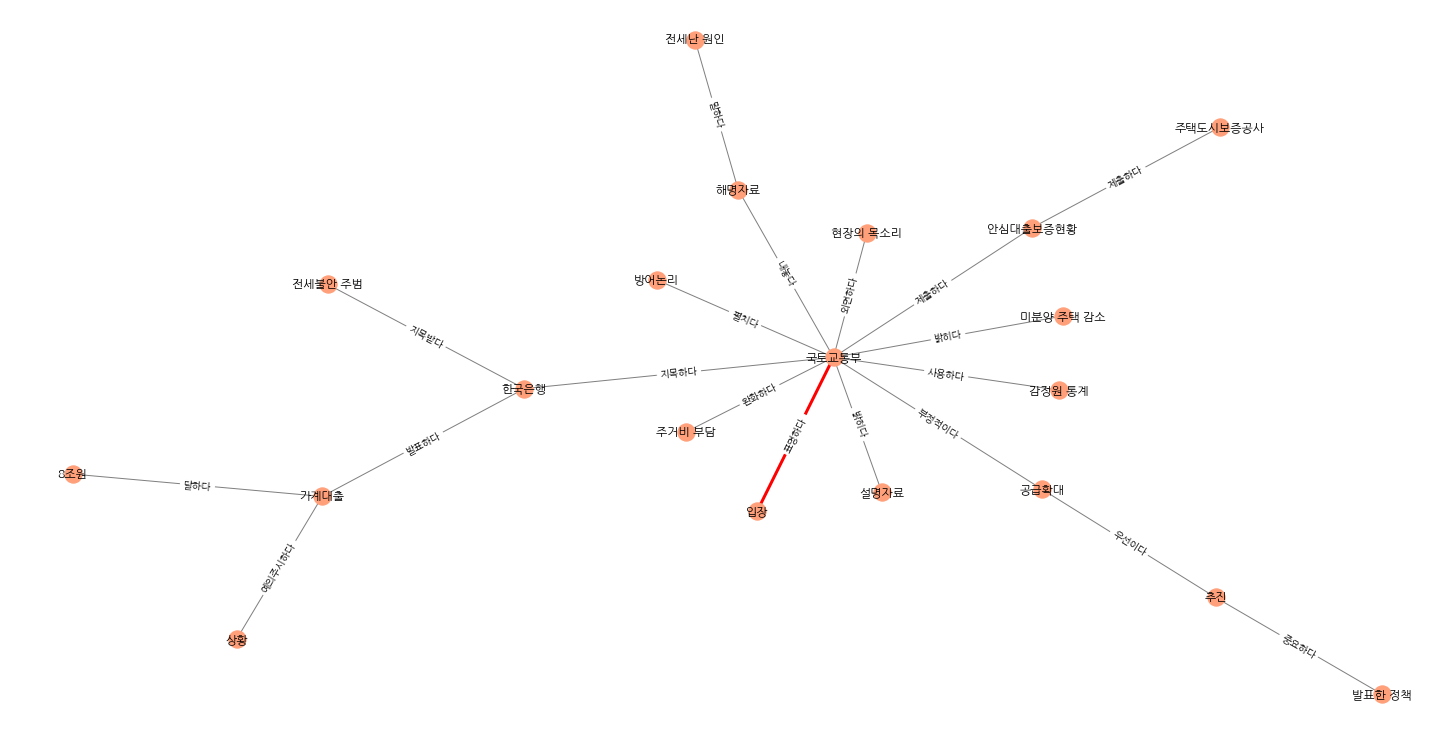

cluster 13


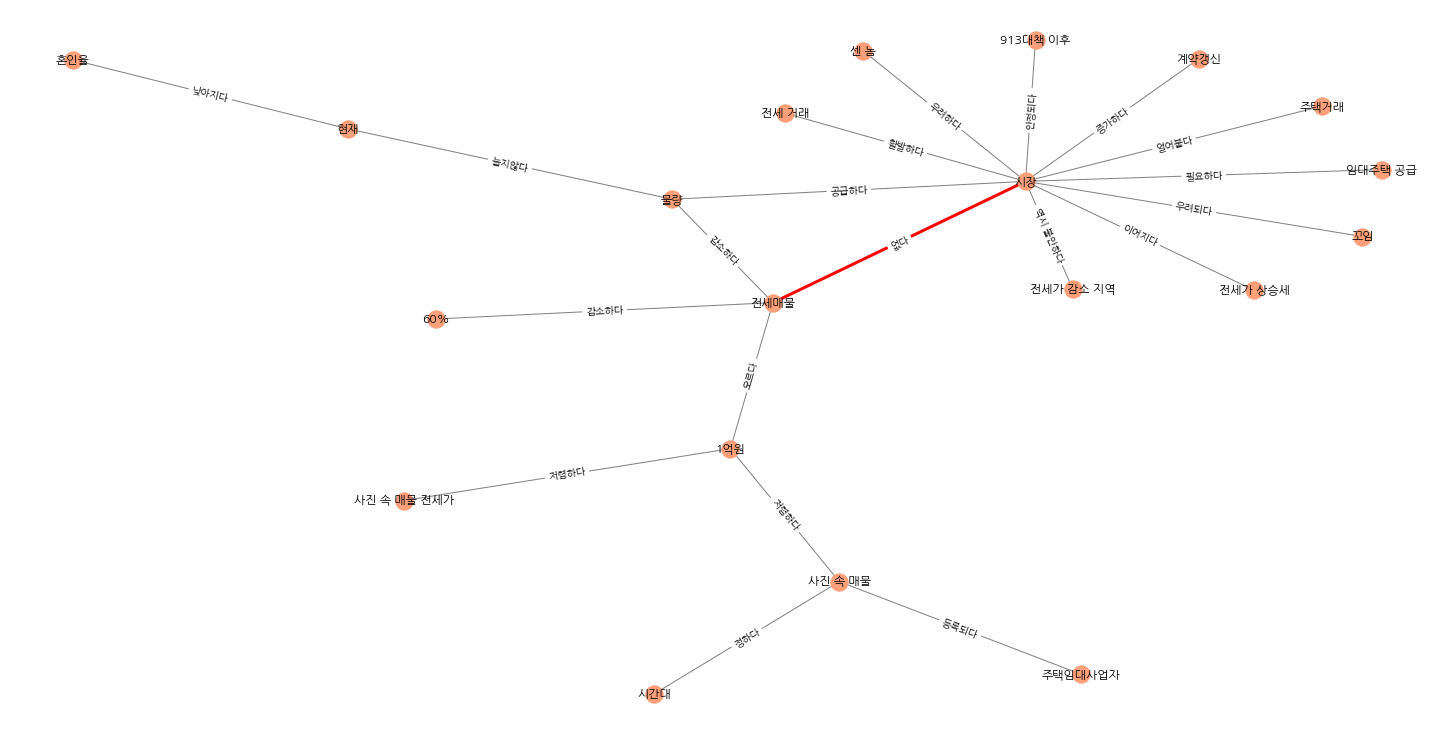

cluster 14


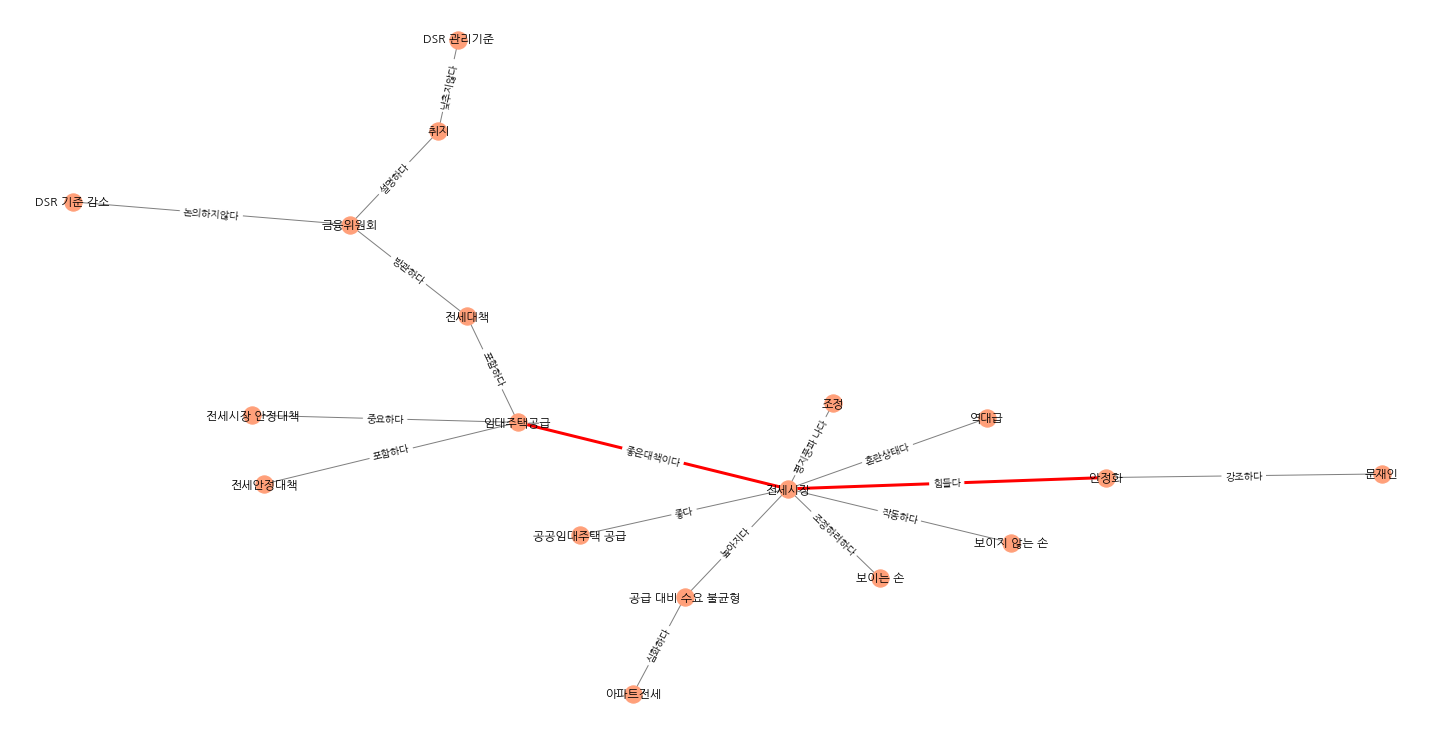

cluster 15


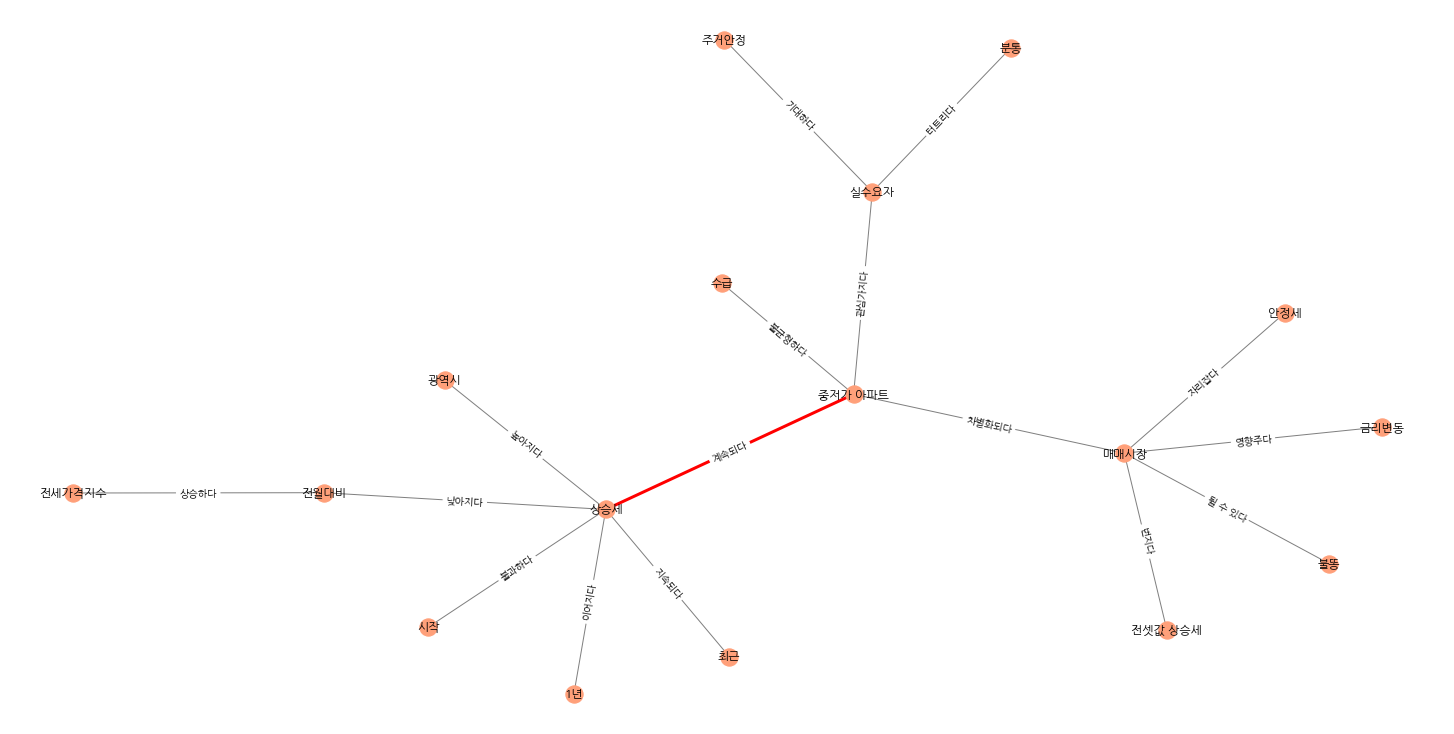

cluster 16


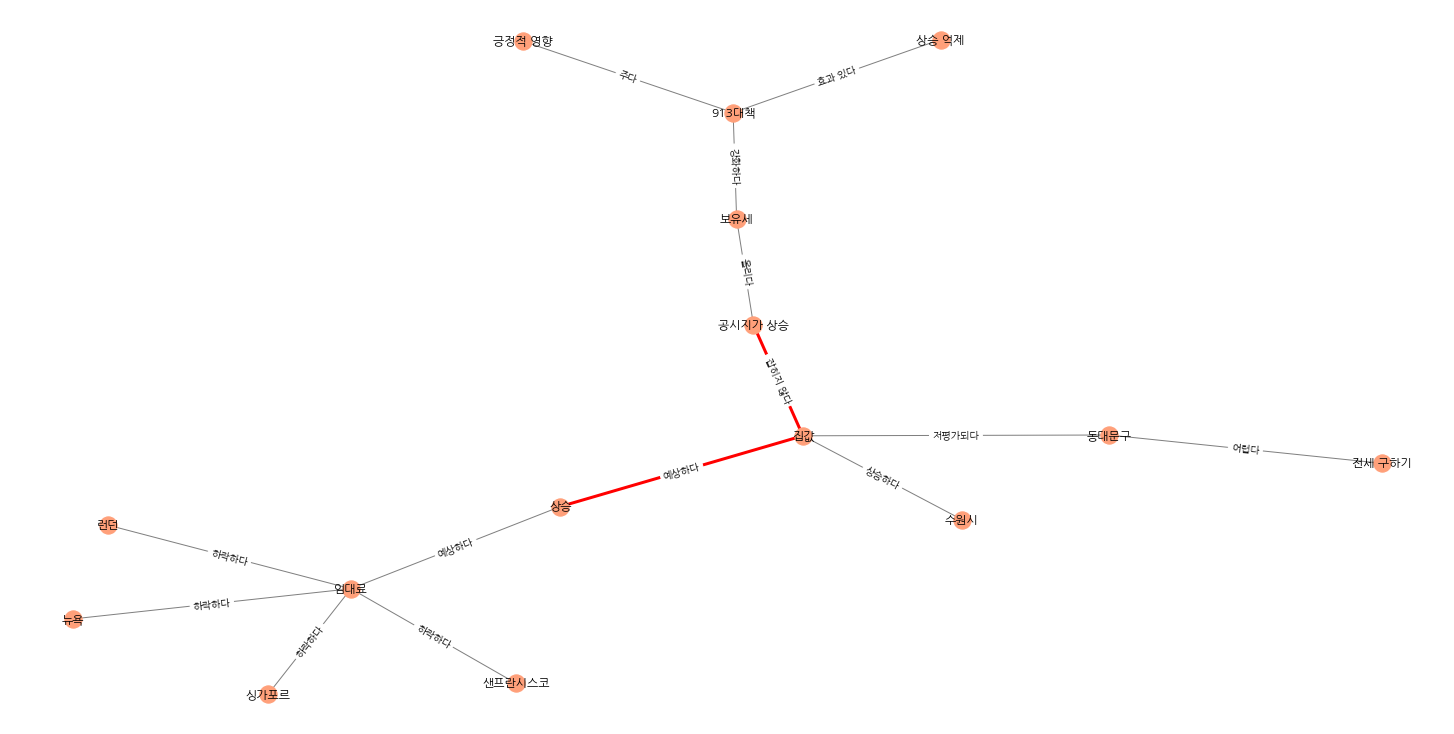

cluster 17


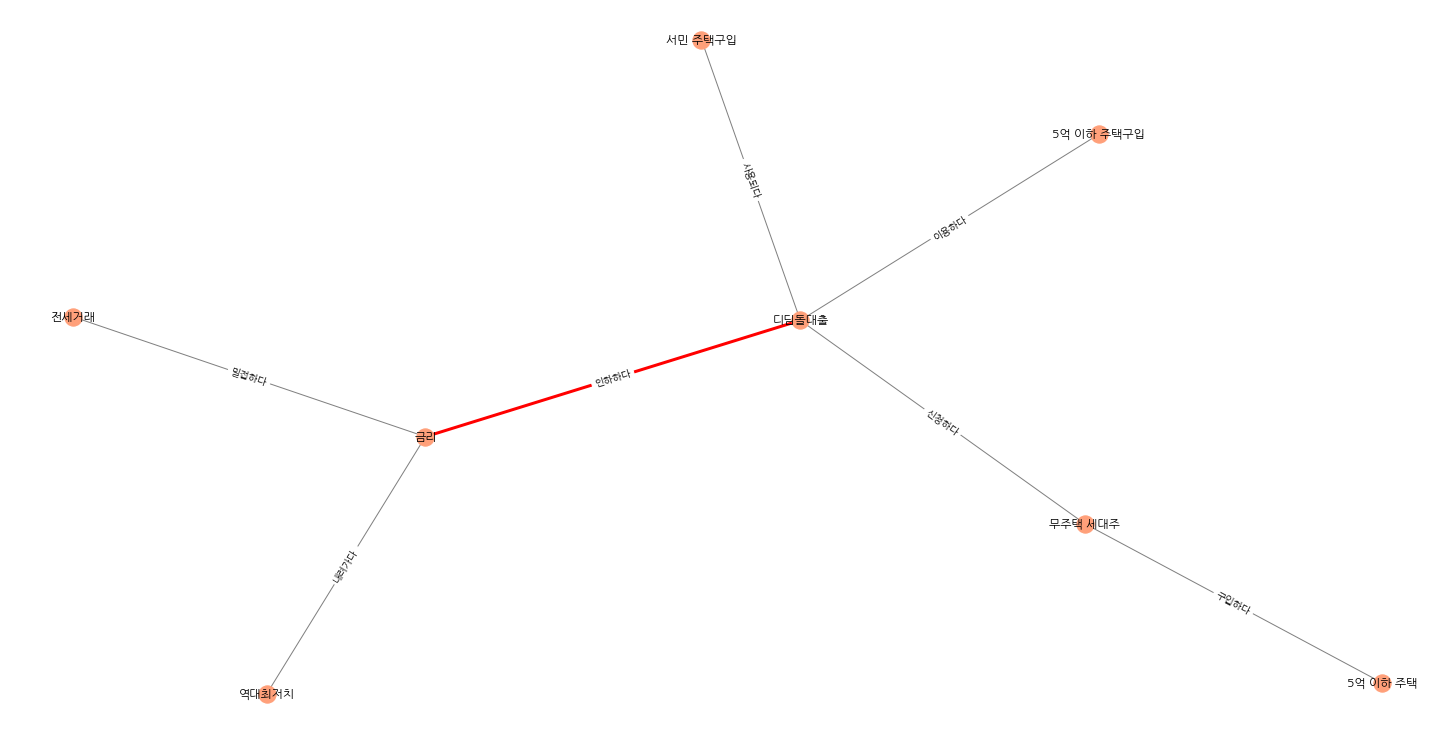

cluster 18


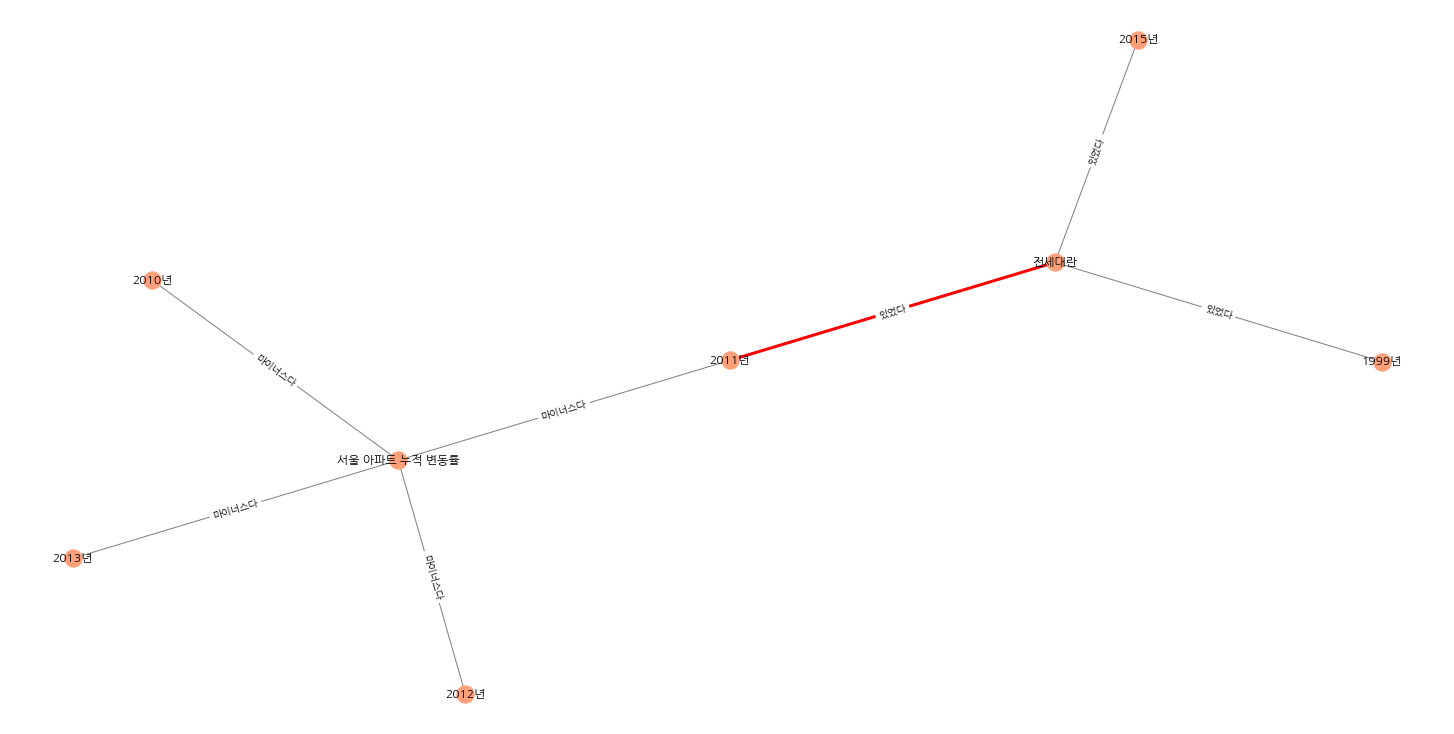

cluster 19


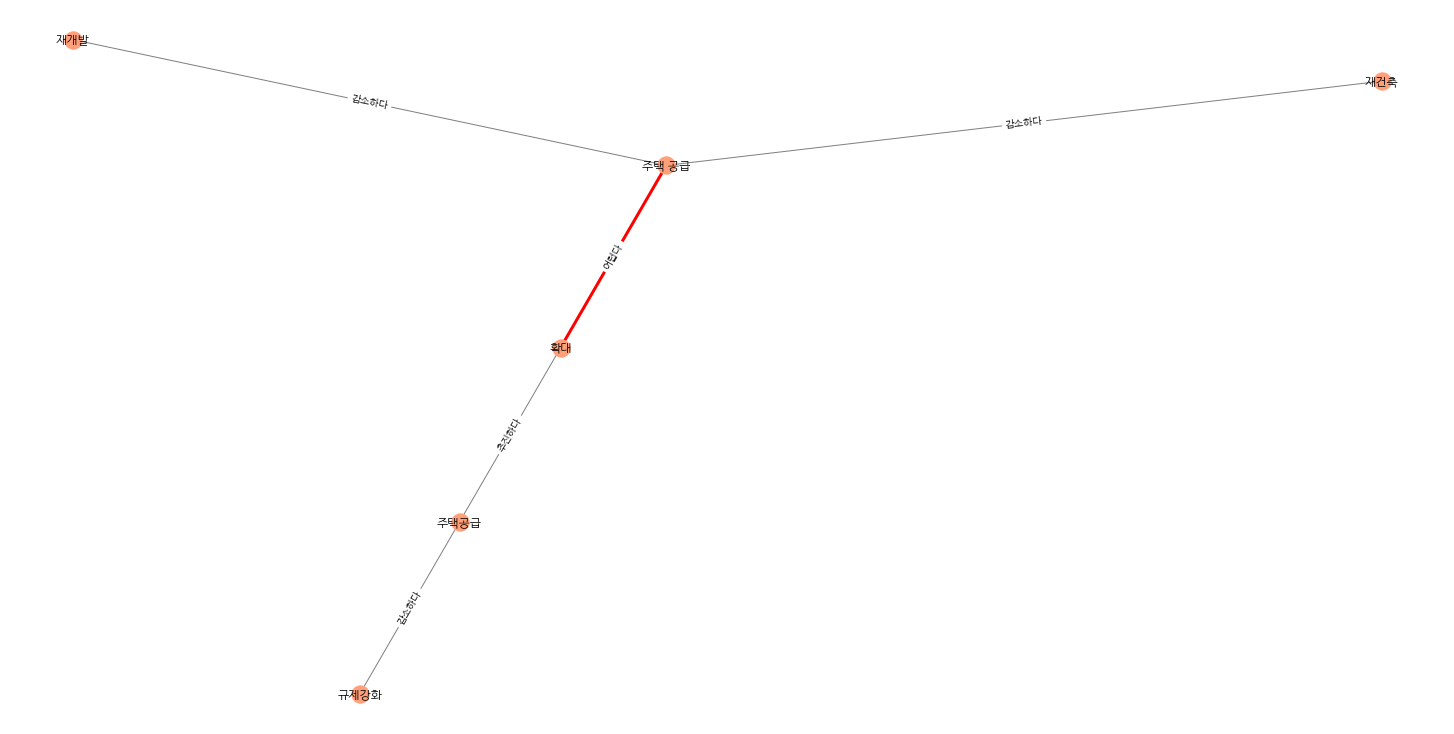

In [19]:
for i in range(len(clusters)):
    G = nx.Graph()
    G.add_nodes_from(nounlist[i])

    nodes = list(spolist[i].keys())
    edges = list(spolist[i].values())

    for j in range(len(nodes)):
        G.add_edges_from([(nodes[j][0], nodes[j][1], {'verb':edges[j]})])

    plt.figure(figsize=(20, 10))
    #레이아웃
    #planar_layout, rescale_layout, fruchterman_reingold_layout, spectral_layout, random_layout, bipartite_layout,
    #circular_layout, spring_layout, kamada_kawai_layout
    pos=nx.kamada_kawai_layout(G) 
    nx.draw(G, pos, with_labels = True, font_weigth = "bold", font_family=font_name, edge_color='gray', node_color='lightsalmon')

    labels = nx.get_edge_attributes(G,'verb')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_family=font_name)
    
    nx.draw_networkx_edges(G, pos, edgelist=key_edges[i], edge_color='r', width=3)
    figname = './NPS_clusters_images/'+str(i)+'.png'
    plt.savefig(figname)
    print('cluster', i)
    plt.show()

전체그래프

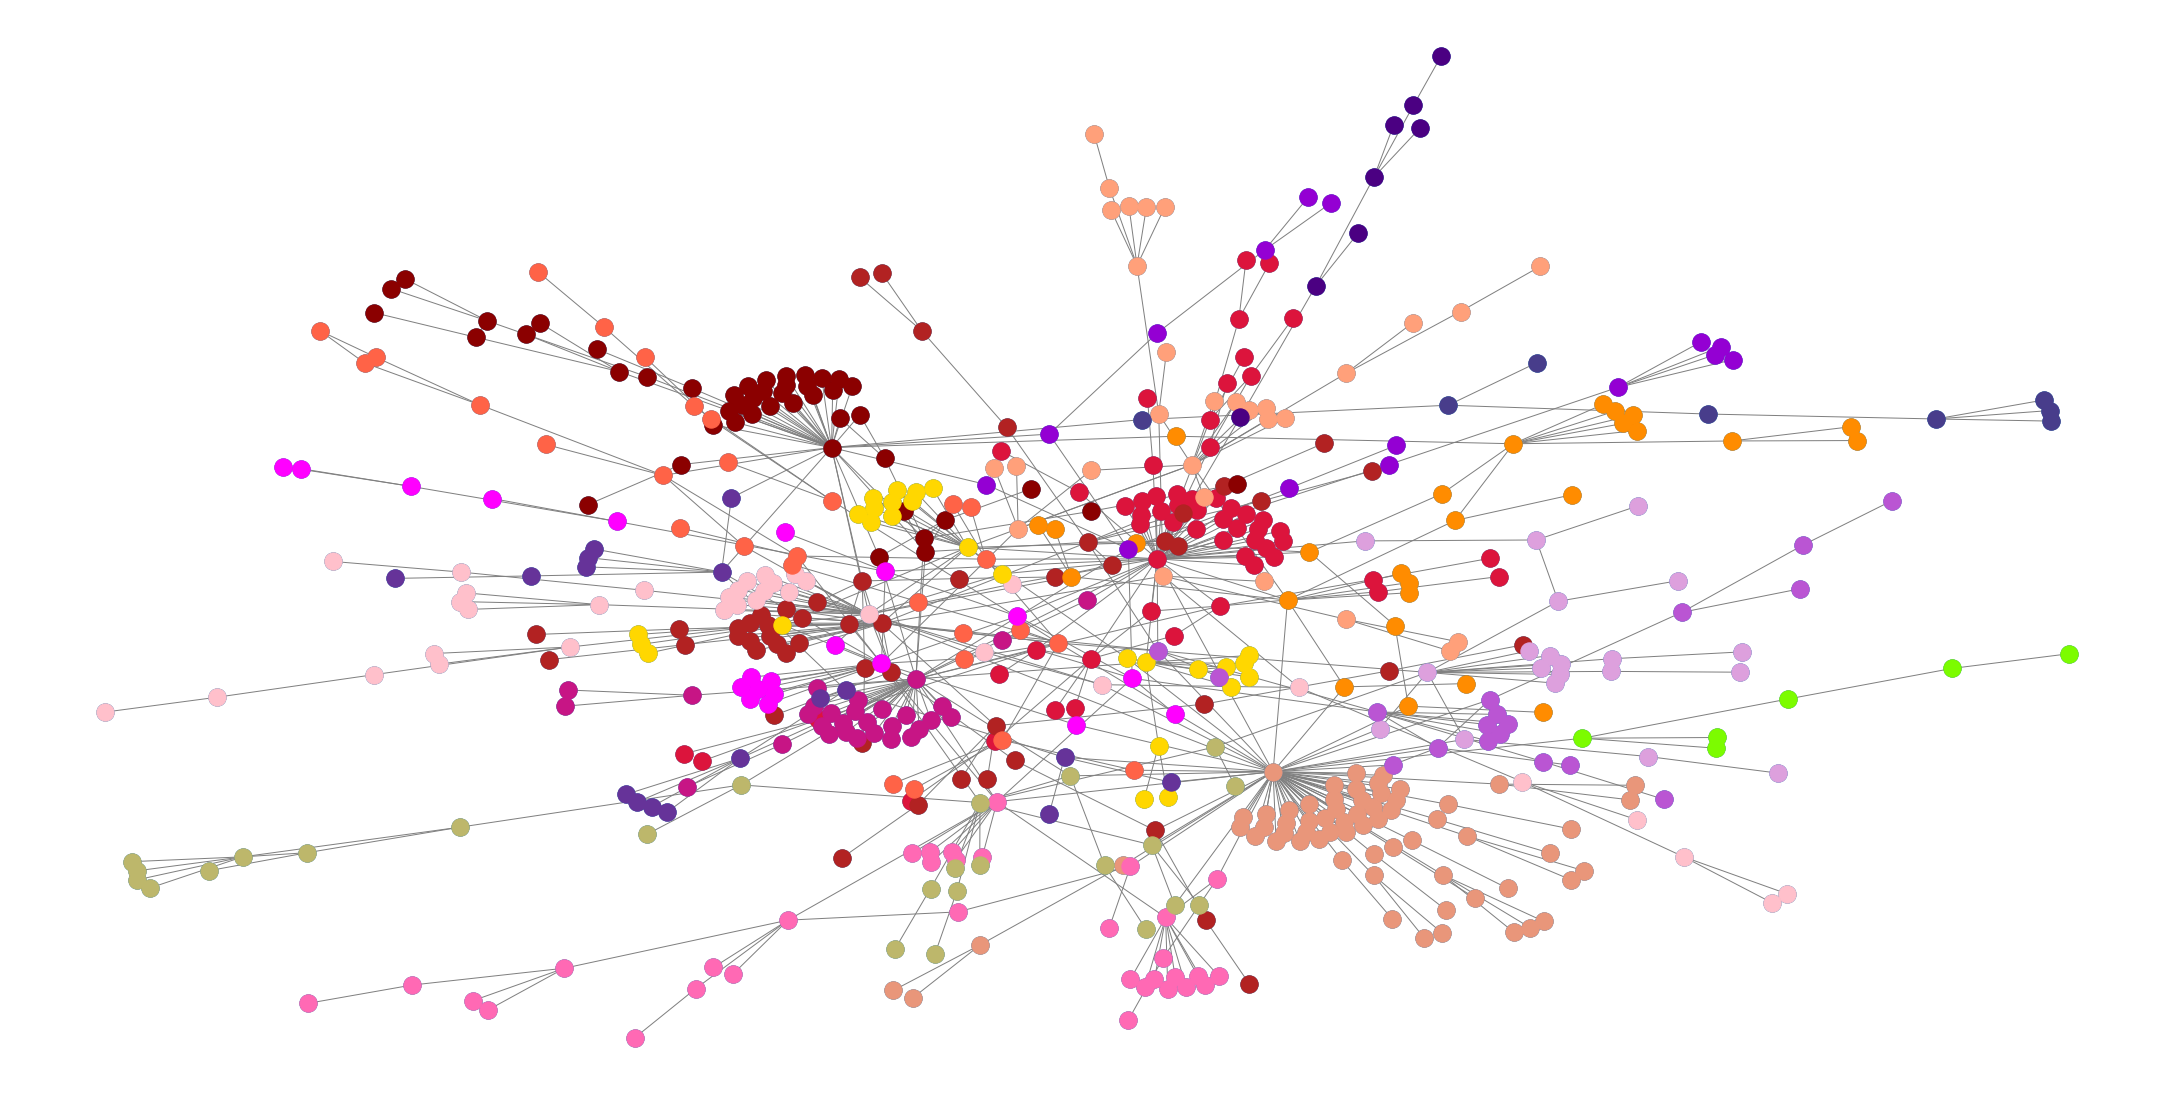

In [18]:
colors = ['#E9967A','#DC143C','#B22222','#8B0000','#FFC0CB','#FF69B4','#C71585','#FFA07A',\
         '#FF6347','#FF8C00','#FFD700','#BDB76B','#DDA0DD','#FF00FF','#BA55D3','#663399','#9400D3',\
         '#4B0082','#483D8B','#7CFC00','#2E8B57','#008000']

#레이아웃
#planar_layout, rescale_layout, fruchterman_reingold_layout, spectral_layout, random_layout, bipartite_layout,
#circular_layout, spring_layout, kamada_kawai_layout

# 전체 그래프 그리기
pos=nx.spring_layout(GC) 
plt.figure(figsize=(30, 15))
# nx.draw(GC, pos, with_labels = True, font_weigth = "bold", font_family=font_name, font_size=5, edge_color='gray')
nx.draw(GC, pos, edge_color='gray')

# 그룹이 n개로 나누어지게 node색 지정
n=len(clusters)
for i in range(n):
    nx.draw_networkx_nodes(GC,pos, nodelist=clusters[i], node_color=colors[i])   

plt.savefig('total_graph.png')

##### 그래프객체 저장(피클)

In [73]:
# import pickle
 
# ## Save pickle
# with open("./NPS_clusters_images/GC_NPS","wb") as fw:
#     pickle.dump(GC, fw)

# with open("./NPS_clusters_images/clusters_NPS","wb") as fw:
#     pickle.dump(clusters, fw)
    
# with open("./NPS_clusters_images/spolist_NPS","wb") as fw:
#     pickle.dump(spolist, fw)

### 주요SPO추출

#### 워드카운트 방식

node_weight 불러오기

In [20]:
# Load pickle
with open("node_weight4","rb") as fr:
    node_weight = pickle.load(fr)


클러스터별 가중치 추출

In [21]:
#nounlist[cluster#]: 각 클러스터의 노드 리스트
#node_weight: 노드의 가중치(센트럴리티 산출 방식마다 달라짐)
for i in range(max_m):
    #각 클러스터의 sub-graph 생성
    cluster_num = i
    print('cluster', cluster_num)
    G = nx.Graph()
    G.add_nodes_from(nounlist[cluster_num])

    nodes = list(spolist[cluster_num].keys())
    edges = list(spolist[cluster_num].values())

    for j in range(len(nodes)):
        G.add_edges_from([(nodes[j][0], nodes[j][1], {'verb':edges[j]})])
    
    #각 군집의 중심 노드 
    cen = nx.degree_centrality(G)
    key_node = sorted(cen.items(), key=lambda x:x[1], reverse=True)[0][0]
    #중심 노드의 이웃 노드들
    ngbs = list(G.neighbors(key_node))
    
    #중심 노드명 출력
    print(key_node, '*')
    
    #각 클러스터별로 불러온 node weight의 값을 노드와 매칭
    temp_dic = {}
    for i in list(nounlist[cluster_num]):
        for j in node_weight.keys():
            if i==j:
                temp_dic[i] = node_weight[i]
    
    #weight가 큰 값 순으로 정렬
    aa = sorted(temp_dic.items(), key=lambda x:x[1], reverse=True)
    
    #
    for i in range(len(aa)):
        if aa[i][0] in ngbs:
            print(aa[i][0], temp_dic[aa[i][0]])
    print('-------------------------------------------------------------')     

cluster 0
정부 *
전세난 안정 152.5
전세시장 안정 131.67
전세시장안정 131.67
전세 대책 발표 115.0
임대인 보호 99.0
시장 존중 대책 54.67
부동산시장 안정 54.67
주택담보대출 54.0
주택가격 안정 47.33
대출 규제 45.5
시장불안정 43.67
전월세 대란 대책 42.0
추가대책 42.0
대책 마련 39.5
대책의 여지 37.5
주택 및 지역 개발부 31.33
공급 확대 31.0
신규대책 발표 28.0
금리탓 27.0
부동산매매 수익 26.33
지분적립형 분양주택 24.5
기존정책 16.0
저금리 원인 12.5
기존 정책 추진 12.0
대북정책 11.5
기존정책 방향성 11.0
서민불안 9.5
취약계층 수급 8.0
실수요자 보호 7.0
공시지가 7.0
재건축 규제 7.0
3+3년 개정안 6.0
표준임대료 도입 5.33
부작용 4.0
인구 감소로 따른 가구 분화 4.0
대응방안 마련 3.67
투기억제 3.0
영향 분석 2.0
오류 2.0
해법 2.0
투기세력 2.0
관계부처간 협의 1.67
검찰개혁 1.0
원희룡 제주지사 1.0
언론 1.0
-------------------------------------------------------------
cluster 1
임대차법 *
전세물량 145.0
전세기간 연장 93.33
정부여당 51.0
부동산시장 과열 42.67
월세전환 29.5
공급불안 28.0
사회적시장경제질서 27.25
전월세상한제 21.67
계약갱신청구권 19.0
계약의 자유 18.0
분쟁 16.0
사업 13.0
정책남발 11.5
국민의 재산권 10.5
국민 기본권 10.0
수급불균형 9.0
임대료 증액 7.5
더불어민주당 5.0
사회적 시장경제질서 5.0
혼란 4.0
사회적 유대감 3.5
사회적 연대 3.5
7월 31일 3.0
위헌 소지 2.5
재산권 침해 2.0
연대 2.0
전문가 2.0
축조심사 1.0
꼼수 1.0
혼선 1.0
전방위 1.0
지적 1.0
3개월 0.1
3달 0.1
세 달 0.1
--

#### NPS distance 방식

In [133]:
dclist = [{'정부': 0.7142857142857142}, {'임대차법': 0.6140350877192982}, {'전세대출': 0.37254901960784315}, {'전셋값': 0.6739130434782609}, {'집주인': 0.5294117647058824}, {'대책': 0.25, '공공임대': 0.34375, '홍남기 경제부총리': 0.1875}, {'전세난': 0.8620689655172413}, {'전세': 0.3793103448275862, '전세수요': 0.20689655172413793}, {'저금리': 0.25, '전세자금대출': 0.14285714285714285, '전셋값 상승': 0.14285714285714285, '원인': 0.14285714285714285, '아파트': 0.14285714285714285}, {'부동산시장': 0.23076923076923078, '임차인': 0.34615384615384615}, {'세입자': 0.5}, {'김현미 장관': 0.3333333333333333, '임대차신고제': 0.25}, {'국토교통부': 0.5789473684210527}, {'시장': 0.5789473684210527}, {'전세시장': 0.47058823529411764}, {'상승세': 0.375}, {'임대료': 0.3571428571428571}, {'디딤돌대출': 0.5714285714285714}, {'서울 아파트 누적 변동률': 0.5714285714285714}, {'주택 공급': 0.6000000000000001}]

In [92]:
dclist

[{'정부': 0.7142857142857142},
 {'임대차법': 0.6140350877192982},
 {'전세대출': 0.37254901960784315},
 {'전셋값': 0.6739130434782609},
 {'집주인': 0.5294117647058824},
 {'대책': 0.25, '공공임대': 0.34375, '홍남기 경제부총리': 0.1875},
 {'전세난': 0.8620689655172413},
 {'전세': 0.3793103448275862, '전세수요': 0.20689655172413793},
 {'저금리': 0.25,
  '전세자금대출': 0.14285714285714285,
  '전셋값 상승': 0.14285714285714285,
  '원인': 0.14285714285714285,
  '아파트': 0.14285714285714285},
 {'부동산시장': 0.23076923076923078, '임차인': 0.34615384615384615},
 {'세입자': 0.5},
 {'김현미 장관': 0.3333333333333333, '임대차신고제': 0.25},
 {'국토교통부': 0.5789473684210527},
 {'시장': 0.5789473684210527},
 {'전세시장': 0.47058823529411764},
 {'상승세': 0.375},
 {'임대료': 0.3571428571428571},
 {'디딤돌대출': 0.5714285714285714},
 {'서울 아파트 누적 변동률': 0.5714285714285714},
 {'주택 공급': 0.6000000000000001}]

In [93]:
list(dclist[1].keys())[0]

'임대차법'

전체 그래프에 대한 노드간 거리 계산

In [154]:
g = GC.copy()
g = nx.convert_node_labels_to_integers(g, label_attribute='noun')
n = g.number_of_nodes()
w = {u: 0 for u in range(n)}
wtot = 0

#weight가 adjacency matrix의 값(노드끼리 연결되어 있으면 1, 아니면 0)
for (u,v) in g.edges():
    if 'weight' not in g[u][v]:
        g[u][v]['weight'] = 1
    weight = g[u][v]['weight']
    #인접행렬에서 행의 합계(혹은 열의 합계) 구하기. 노드별로 값이 나옴. 
    w[u] += weight
    w[v] += weight
    wtot += weight
    #wtot: 인접행렬의 전체 합계(diagonal 제외)
    if u != v:
        wtot += weight

#거리 계산하여 할당 d(i,j) = p(i)*p(j)/p(i,j) 
for (u,v) in g.edges():
    if 'distance' not in g[u][v]:
        d = w[u] * w[v] / float(g[u][v]['weight']) / float(wtot)
        g[u][v]['distance'] = d

클러스터별로 추출

In [156]:
diclist = []
for i in range(max_m):

    print('cluster', i)
    
    dic = {}
    key_nodes = list(dclist[i].keys())
    

    for u in opt_clusters[i]:
        for v in opt_clusters[i]:
            try:
                a = old_nodes[u]
                b = old_nodes[v]
                for keynode in key_nodes:                    
                    if a == keynode:                      
                        dic[(a,b)] = g[u][v]['distance']
                        #print(keynode, '*************************************')
                        print(a, b, g[u][v]['distance'])
            except KeyError:
                continue
    diclist.append(dic)
    #print(sorted(dic.items(), key=lambda x:x[1], reverse=True))

cluster 0
정부 3+3년 개정안 0.1608761329305136
정부 추가대책 0.1608761329305136
정부 부작용 0.1608761329305136
정부 주택담보대출 0.10725075528700906
정부 해법 0.10725075528700906
정부 오류 0.10725075528700906
정부 기존정책 0.10725075528700906
정부 주택 및 지역 개발부 0.10725075528700906
정부 공급 확대 0.05362537764350453
정부 실수요자 보호 0.05362537764350453
정부 전세난 안정 0.05362537764350453
정부 대출 규제 0.05362537764350453
정부 대응방안 마련 0.05362537764350453
정부 서민불안 0.05362537764350453
정부 금리탓 0.05362537764350453
정부 관계부처간 협의 0.05362537764350453
정부 투기세력 0.05362537764350453
정부 재건축 규제 0.05362537764350453
정부 시장불안정 0.05362537764350453
정부 전세시장 안정 0.05362537764350453
정부 표준임대료 도입 0.05362537764350453
정부 취약계층 수급 0.05362537764350453
정부 시장 존중 대책 0.05362537764350453
정부 부동산매매 수익 0.05362537764350453
정부 검찰개혁 0.05362537764350453
정부 인구 감소로 따른 가구 분화 0.05362537764350453
정부 전세 대책 발표 0.05362537764350453
정부 언론 0.05362537764350453
정부 원희룡 제주지사 0.05362537764350453
정부 기존정책 방향성 0.05362537764350453
정부 영향 분석 0.05362537764350453
정부 대책 마련 0.05362537764350453
정부 기존 정책 추진 0.05362537764350453


In [147]:
aa = list(diclist[5].keys())
bb = list(dclist[5].keys())
cc = {}
for i in range(len(aa)):
    for j in bb:
        aa[i][0] == bb:
            

('홍남기 경제부총리', '조은산')

In [151]:
list(dclist[5].keys())

dict_keys(['대책', '공공임대', '홍남기 경제부총리'])

In [153]:
diclist[5]

{('홍남기 경제부총리', '조은산'): 0.01812688821752266,
 ('홍남기 경제부총리', '개인생활'): 0.004531722054380665,
 ('홍남기 경제부총리', '전세 난민'): 0.004531722054380665,
 ('홍남기 경제부총리', '과거대책'): 0.00906344410876133,
 ('홍남기 경제부총리', '정책방향'): 0.00906344410876133,
 ('홍남기 경제부총리', '대책'): 0.054380664652567974,
 ('대책', '홍남기 경제부총리'): 0.054380664652567974,
 ('대책', '속도'): 0.00906344410876133,
 ('대책', '전세시장 불안정성'): 0.00906344410876133,
 ('대책', '전세시장 불안정'): 0.00906344410876133,
 ('대책', '관계부처'): 0.00906344410876133,
 ('대책', '기존 정책'): 0.00906344410876133,
 ('대책', '공공임대주택'): 0.00906344410876133,
 ('대책', '공공임대'): 0.10876132930513595,
 ('공공임대', '대책'): 0.10876132930513595,
 ('공공임대', '지속성'): 0.00906344410876133,
 ('공공임대', '도움'): 0.00906344410876133,
 ('공공임대', '중대형 평형'): 0.00906344410876133,
 ('공공임대', '평형'): 0.00906344410876133,
 ('공공임대', '정부역할'): 0.00906344410876133,
 ('공공임대', '사업성'): 0.00906344410876133,
 ('공공임대', '반응'): 0.00906344410876133,
 ('공공임대', '11월'): 0.00906344410876133,
 ('공공임대', '연봉 1억원'): 0.00906344410876133,
 ('공공임대', '공급대책'

In [47]:
g.number_of_edges()

662

In [43]:
G = nx.Graph()
G.add_nodes_from(nounlist[0])

nodes = list(spolist[0].keys())
edges = list(spolist[0].values())

for j in range(len(nodes)):
    G.add_edges_from([(nodes[j][0], nodes[j][1], {'verb':edges[j]})])

In [45]:
G.edges()

EdgeView([('대책의 여지', '정부'), ('검찰개혁', '정부'), ('전세 대책 발표', '정부'), ('부동산매매 수익', '정부'), ('대북정책', '정부'), ('실수요자보호', '의지'), ('공급 확대', '정부'), ('정부', '3+3년 개정안'), ('정부', '추가대책'), ('정부', '부작용'), ('정부', '주택담보대출'), ('정부', '해법'), ('정부', '오류'), ('정부', '기존정책'), ('정부', '주택 및 지역 개발부'), ('정부', '언론'), ('정부', '원희룡 제주지사'), ('정부', '기존정책 방향성'), ('정부', '영향 분석'), ('정부', '대책 마련'), ('정부', '기존 정책 추진'), ('정부', '신규대책 발표'), ('정부', '임대인 보호'), ('정부', '전세시장안정'), ('정부', '저금리 원인'), ('정부', '전월세 대란 대책'), ('정부', '공시지가'), ('정부', '주택가격 안정'), ('정부', '지분적립형 분양주택'), ('정부', '실수요자 보호'), ('정부', '전세난 안정'), ('정부', '대출 규제'), ('정부', '대응방안 마련'), ('정부', '서민불안'), ('정부', '금리탓'), ('정부', '관계부처간 협의'), ('정부', '투기세력'), ('정부', '재건축 규제'), ('정부', '시장불안정'), ('정부', '전세시장 안정'), ('정부', '표준임대료 도입'), ('정부', '취약계층 수급'), ('정부', '시장 존중 대책'), ('정부', '인구 감소로 따른 가구 분화'), ('정부', '부동산시장 안정'), ('정부', '투기억제'), ('무조건', '추가대책'), ('주택담보대출', '27.40%'), ('기존정책', '응답자 38.8%'), ('자체수급', '부동산시장 안정'), ('목적지', '오류'), ('투기억제', '의지'), ('부작용', '다른 곳'), ('부작용', '국민들 신음'), ('부

0.0017605633802816902
0.00528169014084507
0.0017605633802816902
0.00528169014084507
0.0017605633802816902
0.0017605633802816902
0.00528169014084507
0.0017605633802816902
0.0017605633802816902
0.0017605633802816902
0.0035211267605633804
0.0017605633802816902
0.0035211267605633804
0.0035211267605633804
0.0017605633802816902
0.0035211267605633804
0.0017605633802816902
0.0035211267605633804
0.0017605633802816902
0.125
0.0017605633802816902
0.0017605633802816902
0.0017605633802816902
0.0017605633802816902
0.0017605633802816902
0.0017605633802816902
0.0017605633802816902
0.0017605633802816902
0.0017605633802816902
0.0017605633802816902
0.0017605633802816902
0.0017605633802816902
0.0017605633802816902
0.0017605633802816902
0.0017605633802816902
0.0017605633802816902
0.0017605633802816902
0.0017605633802816902
0.0017605633802816902
0.0017605633802816902
0.0017605633802816902
0.0017605633802816902
0.0017605633802816902
0.0017605633802816902
0.0017605633802816902
0.0017605633802816902
0.00176056

In [37]:
sorted(dic.items(), key=lambda x:x[1], reverse=True)

[(('정부', '지분적립형 분양주택'), 0.21450151057401812),
 (('정부', '3+3년 개정안'), 0.1608761329305136),
 (('정부', '추가대책'), 0.1608761329305136),
 (('정부', '부작용'), 0.1608761329305136),
 (('정부', '주택담보대출'), 0.10725075528700906),
 (('정부', '해법'), 0.10725075528700906),
 (('정부', '오류'), 0.10725075528700906),
 (('정부', '기존정책'), 0.10725075528700906),
 (('정부', '주택 및 지역 개발부'), 0.10725075528700906),
 (('정부', '부동산시장 안정'), 0.10725075528700906),
 (('정부', '투기억제'), 0.10725075528700906),
 (('정부', '공급 확대'), 0.05362537764350453),
 (('정부', '실수요자 보호'), 0.05362537764350453),
 (('정부', '전세난 안정'), 0.05362537764350453),
 (('정부', '대출 규제'), 0.05362537764350453),
 (('정부', '대응방안 마련'), 0.05362537764350453),
 (('정부', '서민불안'), 0.05362537764350453),
 (('정부', '금리탓'), 0.05362537764350453),
 (('정부', '관계부처간 협의'), 0.05362537764350453),
 (('정부', '투기세력'), 0.05362537764350453),
 (('정부', '재건축 규제'), 0.05362537764350453),
 (('정부', '시장불안정'), 0.05362537764350453),
 (('정부', '전세시장 안정'), 0.05362537764350453),
 (('정부', '표준임대료 도입'), 0.05362537764350453),
 (

In [ ]:
#nounlist[cluster#]: 각 클러스터의 노드 리스트
#node_weight: 노드의 가중치(센트럴리티 산출 방식마다 달라짐)
for i in range(max_m):
    cluster_num = i
    print('cluster', cluster_num)
    G = nx.Graph()
    G.add_nodes_from(nounlist[cluster_num])

    nodes = list(spolist[cluster_num].keys())
    edges = list(spolist[cluster_num].values())

    for j in range(len(nodes)):
        G.add_edges_from([(nodes[j][0], nodes[j][1], {'verb':edges[j]})])
    
    #각 군집의 중심 노드 
    cen = nx.degree_centrality(G)
    key_node = sorted(cen.items(), key=lambda x:x[1], reverse=True)[0][0]
    #중심 노드의 이웃 노드들
    ngbs = list(G.neighbors(key_node))
    
    #중심 노드명 출력
    print(key_node, '*')
    
    #각 클러스터별로 불러온 node weight의 값을 노드와 매칭
    temp_dic = {}
    for i in list(nounlist[cluster_num]):
        for j in node_weight.keys():
            if i==j:
                temp_dic[i] = node_weight[i]
    
    #weight가 큰 값 순으로 정렬
    aa = sorted(temp_dic.items(), key=lambda x:x[1], reverse=True)
    
    #
    for i in range(len(aa)):
        if aa[i][0] in ngbs:
            print(aa[i][0], temp_dic[aa[i][0]])
    print('-------------------------------------------------------------')     

In [22]:
dd = {}
for (u,v) in g.edges():
    if u==39 or v==39:
        dd[(u,v)] = g[u][v]['distance']
        #print((u,v),'distance:', g[u][v]['distance'])
sorted(dd.items(), key=lambda x:x[1])

[((39, 137), 0.030211480362537766)]